In [1]:
import pickle
import gzip
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot
from matplotlib import pyplot as plt

filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()



In [2]:
## Load USPS on Python 3.x

from PIL import Image
import os
import numpy as np

USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [3]:
len(USPSMat)

19999

In [4]:
len(USPSTar)

19999

In [5]:
X_train, y_train = training_data
X_cv, y_cv = validation_data
X_test, y_test = test_data


In [6]:
def getOneHot(y):
    y_OH = np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        y_OH[i,y[i]]=1
    return y_OH

In [7]:
def one_hot_sanity_check(y,y_OH):
    for i in range(y.shape[0]):
        if np.argmax(y_OH[i])!=y[i]:
            print('sanity check failed at index: '+str(i))
            return False
    return True

In [8]:
def softmax(z):
    # TODO: try removing add reshape(-1,1) and check broadcasting.
    z = z-np.max(z,axis=1).reshape((-1,1))
    numerators = np.exp(z)
    sum_terms = np.sum(np.exp(z),axis=1).reshape((-1,1))
    return numerators/sum_terms

In [9]:
# referred from stackoverflow.
def cross_entropy_loss(yhat, y):
    # TODO: Add reularization loss.
    return - np.sum(y * np.log(yhat+1e-6))

In [10]:
def add_bias_term(X):
    return(np.concatenate((np.ones((X.shape[0],1)),X),axis=1)) 
    

### Simple Softmax Logistic Regression

In [11]:
def gradient_descent(X_train,y_OH,alpha=0.01,reg_param=2,iterations=1000):
    W            = np.random.randn(X_train.shape[1],10)*0.001
    W            = np.concatenate((np.zeros((1,10)),W),axis=0)
    X_train      = add_bias_term(X_train)
    La           = reg_param
    learningRate = alpha
    loss         =[]
    for i in tqdm(range(0,iterations)):
        activations   = np.dot(X_train,W)
        softmax_probs = softmax(activations)
        delta_E       = -np.dot(X_train.T,(y_OH - softmax_probs)) 
        reg_term = np.dot(reg_param,W[1:,:])
        update_term_0 = -np.dot((alpha/X_train.shape[0]),delta_E[0,:])
        update_terms = -np.dot((alpha/X_train.shape[0]),np.add(delta_E[1:,:],reg_term))
        W[0]=np.add(W[0],update_term_0)
        W[1:,:]=np.add(W[1:,:],update_terms)        
        loss.append(cross_entropy_loss(softmax_probs,y_OH))
    plt.plot(loss)
    return W

In [12]:
def gradient_descent_mini_batch(X_train,y_OH,alpha=0.01,reg_param=2,batch_size=500,iterations=1000):
    W            = np.random.randn(X_train.shape[1],10)*0.001
    W            = np.concatenate((np.zeros((1,10)),W),axis=0)
    X_train      = add_bias_term(X_train)
    La           = reg_param
    learningRate = alpha
    loss         =[]
    for i in tqdm(range(0,iterations)):
        start = (i*batch_size)  % (y_OH.shape[0] - batch_size)
        end = start + batch_size
        X = X_train[start:end,:]
        y = y_OH[start:end,:]
        activations   = np.dot(X,W)
        softmax_probs = softmax(activations)
        delta_E       = -np.dot(X.T,(y - softmax_probs)) 
        reg_term      =  np.dot(reg_param,W[1:,:])
        update_term_0 = -np.dot((alpha/X.shape[0]),delta_E[0,:])
        update_terms  = -np.dot((alpha/X.shape[0]),np.add(delta_E[1:,:],reg_term))
        W[0]=np.add(W[0],update_term_0)
        W[1:,:]=np.add(W[1:,:],update_terms)        
        loss.append(cross_entropy_loss(softmax_probs,y))
    plt.plot(loss)
    return W

In [13]:
y_train_OH = getOneHot(y_train)
y_cv_OH    = getOneHot(y_cv)
y_test_OH  = getOneHot(y_test)

In [14]:
one_hot_sanity_check(y_train,y_train_OH)

True

In [15]:
one_hot_sanity_check(y_cv,y_cv_OH)

True

In [16]:
one_hot_sanity_check(y_test,y_test_OH)

True

100%|██████████| 80000/80000 [02:07<00:00, 625.87it/s] 


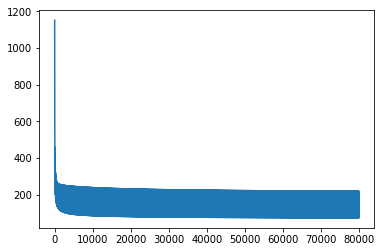

In [23]:
W_trained = gradient_descent_mini_batch(X_train,y_train_OH,alpha=0.09,reg_param=0.03,iterations=80000)


In [24]:
train_pred = softmax(np.dot(add_bias_term(X_train),W_trained))
cv_pred = softmax(np.dot(add_bias_term(X_cv),W_trained))
test_pred = softmax(np.dot(add_bias_term(X_test),W_trained))

preds = np.argmax(train_pred,axis=1)
print(np.mean(y_train== preds))

preds = np.argmax(cv_pred,axis=1)
print(np.mean(y_cv== preds))

preds = np.argmax(test_pred,axis=1)
print(np.mean(y_test== preds))


0.93308
0.9304
0.926


In [25]:
loss

NameError: name 'loss' is not defined

In [44]:
X_USPS = np.array(USPSMat)
y_USPS = np.array(USPSTar)

X_USPS = add_bias_term(X_USPS)
y_USPS_OH = getOneHot(y_USPS)

usps_pred = softmax(np.dot(X_USPS,W_trained))
preds = np.argmax(usps_pred,axis=1)
print(np.mean(y_USPS== preds))

0.31676583829191457


In [20]:
one_hot_sanity_check(y_USPS,y_USPS_OH)

True

### Hyperparameter tuning for Softmax Logistic Regression

##### Tuning reguralization parameter:

In [17]:
lambda_range=[0,0.01,0.02,0.04,0.08,0.1,0.2,0.4,0.8,1,1.5,2,2.5,3]

100%|██████████| 60000/60000 [02:35<00:00, 385.75it/s] 


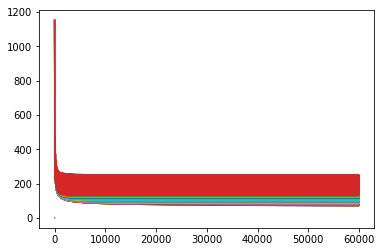

In [18]:
cv_accuracies=[]
for la in lambda_range:
    W_trained  = gradient_descent_mini_batch(X_train,y_train_OH,alpha=0.09,reg_param=la,iterations=60000)   
    train_pred = softmax(np.dot(add_bias_term(X_train),W_trained))
    cv_pred    = softmax(np.dot(add_bias_term(X_cv),W_trained))
    test_pred  = softmax(np.dot(add_bias_term(X_test),W_trained))

    cv_preds = np.argmax(cv_pred,axis=1)
    cv_accuracies.append(np.mean(y_cv== cv_preds))

plt.plot(lambda_range,cv_accuracies)   

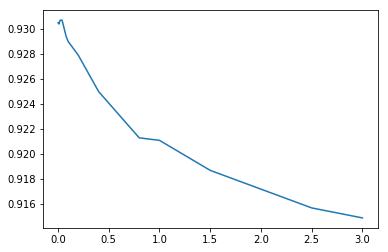

In [19]:
plt.plot(lambda_range,cv_accuracies)

In [ ]:
alpha_range = [0.01,0.03,0.09,0.15,0.27,0.81,1,1.5]
cv_accuracies = []
for alpha in alpha_range:
    W_trained  = gradient_descent_mini_batch(X_train,y_train_OH,alpha=alpha,reg_param=0,iterations=80000)   
    train_pred = softmax(np.dot(add_bias_term(X_train),W_trained))
    cv_pred    = softmax(np.dot(add_bias_term(X_cv),W_trained))
    test_pred  = softmax(np.dot(add_bias_term(X_test),W_trained))

    cv_preds = np.argmax(cv_pred,axis=1)
    cv_accuracies.append(np.mean(y_cv == cv_preds))

plt.plot(alpha_range,cv_accuracies) 

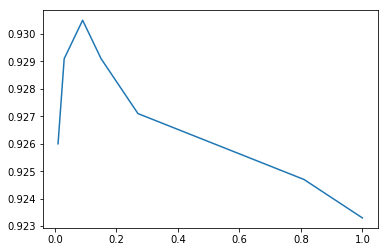

In [52]:
plt.plot(alpha_range,cv_accuracies)

### Radial Basis Softmax regression

In [119]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic=False):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 100):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.pinv(BigSigma)
    for C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y


In [230]:
def gradient_descent_basis(TRAINING_PHI,y_OH,m,alpha=0.01,reg_param=2,iterations=1000):
    W_Now        = np.random.randn(m,10)*0.001
    La           = reg_param
    learningRate = alpha
    loss         =[]
    for i in tqdm(range(0,iterations)):
        activations   = np.dot(TRAINING_PHI,W_Now)
        softmax_probs = softmax(activations)
        Delta_E_D     = -np.dot(TRAINING_PHI.T,(y_OH - softmax_probs)) 
        La_Delta_E_W  = np.dot(La,W_Now) #Computes the partial derivate of regularization term
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)  # Sums up above two derivatives to give the complete derivate of a regularized cost function.
        Delta_W       = -np.dot(learningRate,Delta_E) # Multiplies the derivative with learning rate
        W_T_Next      = W_Now + (Delta_W/y_OH.shape[0]) #Updates the weights by adding the above calculated derivative.
        W_Now         = W_T_Next
        loss.append(cross_entropy_loss(softmax_probs,y_OH))
    plt.plot(loss)
    return W_Now

In [231]:
def softmax_logistic_regression_basis(X_train,y_train,X_cv,y_cv,X_test,y_test,m=10,learning_rate=0.01,la=2,iterate=10000):
    kmeans = KMeans(n_clusters=m, random_state=0).fit(X_train) # Cluster the data to create centroids (mean values) which will be used to compute gaussian kernals 
    Mu = kmeans.cluster_centers_ #matrix containing the mean values of features for every data point in each cluster
    BigSigma     = GenerateBigSigma(X_train.T, Mu, 100) # compute the covariance Matrix
    TRAINING_PHI = GetPhiMatrix(X_train.T, Mu, BigSigma, 100) # Compute the Gaussian radial basis for training data.
    TEST_PHI     = GetPhiMatrix(X_test.T, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(X_cv.T, Mu, BigSigma, 100)
    W_trained    = gradient_descent(TRAINING_PHI,y_train,m,alpha=learning_rate,reg_param=la,iterations=iterate)
   
    train_pred = softmax(np.dot(TRAINING_PHI,W_trained))
    cv_pred = softmax(np.dot(VAL_PHI,W_trained))
    test_pred = softmax(np.dot(TEST_PHI,W_trained))
    return (train_pred,cv_pred,test_pred)

In [241]:
np.concatenate((np.ones((3,1)),np.zeros((3,3))),axis=1)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [180]:
one_hot_sanity_check(y_train,y_train_OH)
y_train_OH.shape

(50000, 10)

In [181]:
one_hot_sanity_check(y_train,y_train_OH)
one_hot_sanity_check(y_cv,y_cv_OH)
one_hot_sanity_check(y_test,y_test_OH)

True

In [182]:
one_hot_sanity_check(y_test,y_test_OH)

True

In [ ]:
W_trained    = gradient_descent(X_train,y_train_OH,m,alpha=0.09,reg_param=2,iterations=100000)

train_pred = softmax(np.dot(X_train,W_trained))
cv_pred = softmax(np.dot(X_cv,W_trained))
test_pred = softmax(np.dot(X_test,W_trained))

preds = np.argmax(test_pred,axis=1)
print(preds.shape)
np.mean(y_test== preds)



  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 8/100000 [00:00<22:56, 72.63it/s]

  0%|          | 16/100000 [00:00<22:42, 73.36it/s]

  0%|          | 24/100000 [00:00<22:10, 75.14it/s]

  0%|          | 32/100000 [00:00<21:48, 76.40it/s]

  0%|          | 40/100000 [00:00<21:44, 76.61it/s]

  0%|          | 49/100000 [00:00<21:19, 78.12it/s]

  0%|          | 57/100000 [00:00<21:10, 78.65it/s]

  0%|          | 66/100000 [00:00<20:54, 79.68it/s]

  0%|          | 74/100000 [00:00<21:17, 78.23it/s]

  0%|          | 82/100000 [00:01<21:16, 78.26it/s]

  0%|          | 91/100000 [00:01<20:58, 79.39it/s]

  0%|          | 99/100000 [00:01<20:58, 79.39it/s]

  0%|          | 107/100000 [00:01<20:56, 79.51it/s]

  0%|          | 115/100000 [00:01<20:58, 79.34it/s]

  0%|          | 123/100000 [00:01<20:56, 79.48it/s]

  0%|          | 132/100000 [00:01<20:47, 80.07it/s]

  0%|          | 140/100000 [00:01<21:41, 76.75it/s]

  0%|          | 148/100000 [00:01<21:33, 77.21it

  2%|▏         | 2297/100000 [00:29<20:38, 78.89it/s]

  2%|▏         | 2305/100000 [00:29<20:53, 77.94it/s]

  2%|▏         | 2314/100000 [00:29<20:33, 79.18it/s]

  2%|▏         | 2323/100000 [00:30<20:13, 80.49it/s]

  2%|▏         | 2332/100000 [00:30<19:58, 81.51it/s]

  2%|▏         | 2341/100000 [00:30<19:48, 82.18it/s]

  2%|▏         | 2350/100000 [00:30<19:42, 82.59it/s]

  2%|▏         | 2359/100000 [00:30<19:40, 82.70it/s]

  2%|▏         | 2368/100000 [00:30<19:23, 83.91it/s]

  2%|▏         | 2377/100000 [00:30<19:23, 83.94it/s]

  2%|▏         | 2386/100000 [00:30<19:29, 83.49it/s]

  2%|▏         | 2395/100000 [00:30<19:34, 83.10it/s]

  2%|▏         | 2404/100000 [00:30<19:27, 83.59it/s]

  2%|▏         | 2413/100000 [00:31<19:23, 83.84it/s]

  2%|▏         | 2422/100000 [00:31<19:27, 83.59it/s]

  2%|▏         | 2431/100000 [00:31<19:25, 83.74it/s]

  2%|▏         | 2440/100000 [00:31<19:29, 83.43it/s]

  2%|▏         | 2449/100000 [00:31<19:19, 84.14it/s]

  2%|▏    

  5%|▍         | 4708/100000 [00:59<17:11, 92.42it/s]

  5%|▍         | 4718/100000 [00:59<17:08, 92.67it/s]

  5%|▍         | 4728/100000 [00:59<17:07, 92.68it/s]

  5%|▍         | 4738/100000 [00:59<17:07, 92.71it/s]

  5%|▍         | 4748/100000 [00:59<17:10, 92.42it/s]

  5%|▍         | 4758/100000 [00:59<17:07, 92.69it/s]

  5%|▍         | 4768/100000 [00:59<17:06, 92.81it/s]

  5%|▍         | 4778/100000 [00:59<17:06, 92.77it/s]

  5%|▍         | 4788/100000 [00:59<17:07, 92.64it/s]

  5%|▍         | 4798/100000 [01:00<17:10, 92.39it/s]

  5%|▍         | 4808/100000 [01:00<17:10, 92.41it/s]

  5%|▍         | 4818/100000 [01:00<17:07, 92.59it/s]

  5%|▍         | 4828/100000 [01:00<17:08, 92.52it/s]

  5%|▍         | 4838/100000 [01:00<17:09, 92.45it/s]

  5%|▍         | 4848/100000 [01:00<17:07, 92.58it/s]

  5%|▍         | 4858/100000 [01:00<17:05, 92.77it/s]

  5%|▍         | 4868/100000 [01:00<17:06, 92.64it/s]

  5%|▍         | 4878/100000 [01:00<17:07, 92.61it/s]

  5%|▍    

  7%|▋         | 7287/100000 [01:28<23:37, 65.42it/s]

  7%|▋         | 7294/100000 [01:28<28:24, 54.40it/s]

  7%|▋         | 7300/100000 [01:29<35:06, 44.01it/s]

  7%|▋         | 7306/100000 [01:29<33:59, 45.46it/s]

  7%|▋         | 7312/100000 [01:29<32:19, 47.80it/s]

  7%|▋         | 7318/100000 [01:29<38:57, 39.66it/s]

  7%|▋         | 7323/100000 [01:29<37:04, 41.66it/s]

  7%|▋         | 7330/100000 [01:29<32:50, 47.03it/s]

  7%|▋         | 7337/100000 [01:29<29:56, 51.57it/s]

  7%|▋         | 7344/100000 [01:29<28:15, 54.64it/s]

  7%|▋         | 7351/100000 [01:30<27:20, 56.48it/s]

  7%|▋         | 7357/100000 [01:30<27:58, 55.18it/s]

  7%|▋         | 7364/100000 [01:30<26:53, 57.42it/s]

  7%|▋         | 7371/100000 [01:30<25:35, 60.31it/s]

  7%|▋         | 7378/100000 [01:30<25:04, 61.58it/s]

  7%|▋         | 7385/100000 [01:30<24:47, 62.27it/s]

  7%|▋         | 7392/100000 [01:30<25:06, 61.46it/s]

  7%|▋         | 7399/100000 [01:30<27:03, 57.05it/s]

  7%|▋    

 10%|▉         | 9768/100000 [01:58<16:41, 90.07it/s]

 10%|▉         | 9778/100000 [01:58<16:45, 89.74it/s]

 10%|▉         | 9788/100000 [01:58<16:40, 90.12it/s]

 10%|▉         | 9798/100000 [01:58<16:37, 90.45it/s]

 10%|▉         | 9808/100000 [01:58<16:35, 90.63it/s]

 10%|▉         | 9818/100000 [01:58<16:35, 90.60it/s]

 10%|▉         | 9828/100000 [01:58<16:35, 90.56it/s]

 10%|▉         | 9838/100000 [01:59<16:34, 90.63it/s]

 10%|▉         | 9848/100000 [01:59<16:31, 90.92it/s]

 10%|▉         | 9858/100000 [01:59<16:46, 89.55it/s]

 10%|▉         | 9868/100000 [01:59<16:43, 89.80it/s]

 10%|▉         | 9877/100000 [01:59<16:50, 89.22it/s]

 10%|▉         | 9886/100000 [01:59<16:49, 89.29it/s]

 10%|▉         | 9896/100000 [01:59<16:45, 89.58it/s]

 10%|▉         | 9906/100000 [01:59<16:44, 89.74it/s]

 10%|▉         | 9916/100000 [01:59<16:37, 90.28it/s]

 10%|▉         | 9926/100000 [02:00<16:36, 90.38it/s]

 10%|▉         | 9936/100000 [02:00<16:32, 90.75it/s]

 10%|▉    

 12%|█▏        | 12397/100000 [02:27<16:24, 88.96it/s]

 12%|█▏        | 12407/100000 [02:27<16:20, 89.30it/s]

 12%|█▏        | 12416/100000 [02:27<16:18, 89.46it/s]

 12%|█▏        | 12425/100000 [02:27<16:19, 89.43it/s]

 12%|█▏        | 12434/100000 [02:27<17:43, 82.34it/s]

 12%|█▏        | 12443/100000 [02:27<18:33, 78.60it/s]

 12%|█▏        | 12451/100000 [02:27<18:48, 77.61it/s]

 12%|█▏        | 12459/100000 [02:28<19:01, 76.68it/s]

 12%|█▏        | 12468/100000 [02:28<18:45, 77.74it/s]

 12%|█▏        | 12477/100000 [02:28<18:13, 80.02it/s]

 12%|█▏        | 12486/100000 [02:28<17:54, 81.43it/s]

 12%|█▏        | 12495/100000 [02:28<18:05, 80.58it/s]

 13%|█▎        | 12504/100000 [02:28<18:36, 78.36it/s]

 13%|█▎        | 12512/100000 [02:28<19:26, 75.02it/s]

 13%|█▎        | 12520/100000 [02:28<19:08, 76.19it/s]

 13%|█▎        | 12528/100000 [02:28<19:14, 75.80it/s]

 13%|█▎        | 12536/100000 [02:29<19:48, 73.56it/s]

 13%|█▎        | 12545/100000 [02:29<19:12, 75.9

 15%|█▍        | 14924/100000 [02:56<18:43, 75.72it/s]

 15%|█▍        | 14933/100000 [02:56<18:06, 78.33it/s]

 15%|█▍        | 14942/100000 [02:56<17:36, 80.48it/s]

 15%|█▍        | 14951/100000 [02:56<17:43, 79.95it/s]

 15%|█▍        | 14960/100000 [02:56<17:51, 79.39it/s]

 15%|█▍        | 14968/100000 [02:57<18:57, 74.74it/s]

 15%|█▍        | 14976/100000 [02:57<19:01, 74.45it/s]

 15%|█▍        | 14984/100000 [02:57<18:43, 75.68it/s]

 15%|█▍        | 14993/100000 [02:57<18:22, 77.10it/s]

 15%|█▌        | 15002/100000 [02:57<17:47, 79.60it/s]

 15%|█▌        | 15012/100000 [02:57<17:10, 82.46it/s]

 15%|█▌        | 15021/100000 [02:57<16:46, 84.44it/s]

 15%|█▌        | 15030/100000 [02:57<16:40, 84.94it/s]

 15%|█▌        | 15039/100000 [02:57<16:30, 85.75it/s]

 15%|█▌        | 15048/100000 [02:57<16:18, 86.84it/s]

 15%|█▌        | 15057/100000 [02:58<16:19, 86.70it/s]

 15%|█▌        | 15067/100000 [02:58<16:04, 88.03it/s]

 15%|█▌        | 15077/100000 [02:58<15:51, 89.2

 18%|█▊        | 17528/100000 [03:24<19:17, 71.23it/s]

 18%|█▊        | 17538/100000 [03:24<17:47, 77.23it/s]

 18%|█▊        | 17548/100000 [03:24<16:43, 82.19it/s]

 18%|█▊        | 17558/100000 [03:24<16:01, 85.73it/s]

 18%|█▊        | 17568/100000 [03:24<15:48, 86.89it/s]

 18%|█▊        | 17577/100000 [03:25<17:02, 80.62it/s]

 18%|█▊        | 17586/100000 [03:25<19:14, 71.36it/s]

 18%|█▊        | 17594/100000 [03:25<20:37, 66.56it/s]

 18%|█▊        | 17601/100000 [03:25<21:24, 64.15it/s]

 18%|█▊        | 17609/100000 [03:25<20:30, 66.94it/s]

 18%|█▊        | 17618/100000 [03:25<19:14, 71.36it/s]

 18%|█▊        | 17627/100000 [03:25<18:14, 75.24it/s]

 18%|█▊        | 17636/100000 [03:25<17:48, 77.06it/s]

 18%|█▊        | 17645/100000 [03:25<17:09, 80.02it/s]

 18%|█▊        | 17654/100000 [03:26<17:22, 78.96it/s]

 18%|█▊        | 17663/100000 [03:26<16:55, 81.05it/s]

 18%|█▊        | 17673/100000 [03:26<16:13, 84.60it/s]

 18%|█▊        | 17683/100000 [03:26<15:31, 88.3

 20%|██        | 20064/100000 [03:53<17:17, 77.07it/s]

 20%|██        | 20072/100000 [03:53<17:44, 75.09it/s]

 20%|██        | 20080/100000 [03:53<18:00, 73.96it/s]

 20%|██        | 20088/100000 [03:53<18:14, 73.03it/s]

 20%|██        | 20096/100000 [03:53<19:06, 69.72it/s]

 20%|██        | 20104/100000 [03:53<19:05, 69.75it/s]

 20%|██        | 20112/100000 [03:53<19:13, 69.29it/s]

 20%|██        | 20119/100000 [03:54<19:36, 67.92it/s]

 20%|██        | 20127/100000 [03:54<19:21, 68.75it/s]

 20%|██        | 20135/100000 [03:54<18:45, 70.96it/s]

 20%|██        | 20143/100000 [03:54<18:34, 71.67it/s]

 20%|██        | 20151/100000 [03:54<18:11, 73.17it/s]

 20%|██        | 20159/100000 [03:54<18:01, 73.84it/s]

 20%|██        | 20167/100000 [03:54<18:02, 73.77it/s]

 20%|██        | 20175/100000 [03:54<18:06, 73.44it/s]

 20%|██        | 20183/100000 [03:54<18:05, 73.52it/s]

 20%|██        | 20192/100000 [03:55<17:28, 76.10it/s]

 20%|██        | 20201/100000 [03:55<17:06, 77.7

 22%|██▏       | 22483/100000 [04:22<13:03, 98.92it/s]

 22%|██▏       | 22493/100000 [04:22<13:02, 99.11it/s]

 23%|██▎       | 22504/100000 [04:22<12:59, 99.41it/s]

 23%|██▎       | 22514/100000 [04:22<13:01, 99.15it/s]

 23%|██▎       | 22524/100000 [04:22<13:03, 98.90it/s]

 23%|██▎       | 22534/100000 [04:22<13:05, 98.65it/s]

 23%|██▎       | 22544/100000 [04:22<13:05, 98.56it/s]

 23%|██▎       | 22554/100000 [04:22<13:04, 98.71it/s]

 23%|██▎       | 22564/100000 [04:22<13:11, 97.81it/s]

 23%|██▎       | 22574/100000 [04:23<13:09, 98.13it/s]

 23%|██▎       | 22584/100000 [04:23<13:04, 98.65it/s]

 23%|██▎       | 22594/100000 [04:23<13:02, 98.93it/s]

 23%|██▎       | 22604/100000 [04:23<13:01, 99.07it/s]

 23%|██▎       | 22614/100000 [04:23<13:00, 99.12it/s]

 23%|██▎       | 22624/100000 [04:23<13:02, 98.86it/s]

 23%|██▎       | 22634/100000 [04:23<13:17, 97.03it/s]

 23%|██▎       | 22644/100000 [04:23<14:12, 90.70it/s]

 23%|██▎       | 22654/100000 [04:23<14:18, 90.1

 25%|██▌       | 25132/100000 [04:48<12:34, 99.26it/s]

 25%|██▌       | 25142/100000 [04:49<12:36, 98.92it/s]

 25%|██▌       | 25152/100000 [04:49<12:46, 97.71it/s]

 25%|██▌       | 25162/100000 [04:49<12:41, 98.29it/s]

 25%|██▌       | 25172/100000 [04:49<12:38, 98.70it/s]

 25%|██▌       | 25182/100000 [04:49<12:38, 98.69it/s]

 25%|██▌       | 25192/100000 [04:49<12:37, 98.78it/s]

 25%|██▌       | 25202/100000 [04:49<12:35, 98.99it/s]

 25%|██▌       | 25212/100000 [04:49<12:33, 99.19it/s]

 25%|██▌       | 25222/100000 [04:49<12:37, 98.65it/s]

 25%|██▌       | 25232/100000 [04:49<12:36, 98.79it/s]

 25%|██▌       | 25242/100000 [04:50<12:36, 98.87it/s]

 25%|██▌       | 25253/100000 [04:50<12:32, 99.31it/s]

 25%|██▌       | 25263/100000 [04:50<12:32, 99.35it/s]

 25%|██▌       | 25273/100000 [04:50<12:32, 99.28it/s]

 25%|██▌       | 25283/100000 [04:50<12:44, 97.70it/s]

 25%|██▌       | 25293/100000 [04:50<12:55, 96.28it/s]

 25%|██▌       | 25303/100000 [04:50<13:08, 94.7

 28%|██▊       | 27776/100000 [05:15<12:24, 96.96it/s]

 28%|██▊       | 27786/100000 [05:16<12:24, 96.94it/s]

 28%|██▊       | 27796/100000 [05:16<12:26, 96.72it/s]

 28%|██▊       | 27806/100000 [05:16<12:26, 96.73it/s]

 28%|██▊       | 27816/100000 [05:16<12:26, 96.74it/s]

 28%|██▊       | 27826/100000 [05:16<12:25, 96.82it/s]

 28%|██▊       | 27836/100000 [05:16<12:23, 97.10it/s]

 28%|██▊       | 27846/100000 [05:16<12:25, 96.82it/s]

 28%|██▊       | 27856/100000 [05:16<12:24, 96.91it/s]

 28%|██▊       | 27866/100000 [05:16<12:24, 96.88it/s]

 28%|██▊       | 27876/100000 [05:16<12:24, 96.85it/s]

 28%|██▊       | 27886/100000 [05:17<12:23, 96.93it/s]

 28%|██▊       | 27896/100000 [05:17<12:21, 97.20it/s]

 28%|██▊       | 27906/100000 [05:17<12:23, 96.91it/s]

 28%|██▊       | 27916/100000 [05:17<12:22, 97.05it/s]

 28%|██▊       | 27926/100000 [05:17<12:21, 97.24it/s]

 28%|██▊       | 27936/100000 [05:17<12:20, 97.30it/s]

 28%|██▊       | 27946/100000 [05:17<12:21, 97.1

 30%|███       | 30415/100000 [05:43<12:36, 91.94it/s]

 30%|███       | 30425/100000 [05:43<12:34, 92.18it/s]

 30%|███       | 30435/100000 [05:43<12:32, 92.46it/s]

 30%|███       | 30445/100000 [05:43<12:30, 92.72it/s]

 30%|███       | 30455/100000 [05:43<12:28, 92.92it/s]

 30%|███       | 30465/100000 [05:43<12:31, 92.56it/s]

 30%|███       | 30475/100000 [05:44<12:41, 91.28it/s]

 30%|███       | 30485/100000 [05:44<12:39, 91.47it/s]

 30%|███       | 30495/100000 [05:44<12:32, 92.37it/s]

 31%|███       | 30505/100000 [05:44<12:25, 93.26it/s]

 31%|███       | 30515/100000 [05:44<12:24, 93.27it/s]

 31%|███       | 30525/100000 [05:44<12:24, 93.31it/s]

 31%|███       | 30535/100000 [05:44<12:17, 94.18it/s]

 31%|███       | 30545/100000 [05:44<12:23, 93.40it/s]

 31%|███       | 30555/100000 [05:44<12:25, 93.15it/s]

 31%|███       | 30565/100000 [05:44<12:12, 94.73it/s]

 31%|███       | 30575/100000 [05:45<12:04, 95.80it/s]

 31%|███       | 30585/100000 [05:45<11:57, 96.7

 33%|███▎      | 33062/100000 [06:10<11:14, 99.24it/s]

 33%|███▎      | 33072/100000 [06:10<11:13, 99.43it/s]

 33%|███▎      | 33082/100000 [06:10<11:13, 99.38it/s]

 33%|███▎      | 33092/100000 [06:10<11:14, 99.14it/s]

 33%|███▎      | 33102/100000 [06:10<11:15, 99.03it/s]

 33%|███▎      | 33112/100000 [06:10<11:15, 98.97it/s]

 33%|███▎      | 33122/100000 [06:10<11:26, 97.41it/s]

 33%|███▎      | 33132/100000 [06:11<11:22, 98.00it/s]

 33%|███▎      | 33142/100000 [06:11<11:24, 97.61it/s]

 33%|███▎      | 33152/100000 [06:11<11:21, 98.08it/s]

 33%|███▎      | 33163/100000 [06:11<11:16, 98.77it/s]

 33%|███▎      | 33173/100000 [06:11<11:15, 98.89it/s]

 33%|███▎      | 33183/100000 [06:11<11:17, 98.57it/s]

 33%|███▎      | 33193/100000 [06:11<11:17, 98.67it/s]

 33%|███▎      | 33203/100000 [06:11<11:17, 98.59it/s]

 33%|███▎      | 33213/100000 [06:11<11:15, 98.89it/s]

 33%|███▎      | 33223/100000 [06:11<11:19, 98.34it/s]

 33%|███▎      | 33233/100000 [06:12<11:17, 98.5

 36%|███▌      | 35719/100000 [06:37<10:47, 99.25it/s]

 36%|███▌      | 35729/100000 [06:37<11:07, 96.28it/s]

 36%|███▌      | 35740/100000 [06:37<10:59, 97.45it/s]

 36%|███▌      | 35750/100000 [06:37<10:55, 98.05it/s]

 36%|███▌      | 35760/100000 [06:37<10:52, 98.39it/s]

 36%|███▌      | 35771/100000 [06:37<10:49, 98.96it/s]

 36%|███▌      | 35781/100000 [06:37<10:51, 98.60it/s]

 36%|███▌      | 35791/100000 [06:37<10:49, 98.87it/s]

 36%|███▌      | 35801/100000 [06:37<10:47, 99.15it/s]

 36%|███▌      | 35811/100000 [06:38<10:47, 99.15it/s]

 36%|███▌      | 35821/100000 [06:38<10:46, 99.20it/s]

 36%|███▌      | 35831/100000 [06:38<10:46, 99.31it/s]

 36%|███▌      | 35842/100000 [06:38<10:44, 99.59it/s]

 36%|███▌      | 35852/100000 [06:38<10:43, 99.69it/s]

 36%|███▌      | 35862/100000 [06:38<10:43, 99.60it/s]

 36%|███▌      | 35872/100000 [06:38<10:47, 99.10it/s]

 36%|███▌      | 35882/100000 [06:38<10:51, 98.45it/s]

 36%|███▌      | 35892/100000 [06:38<10:49, 98.6

 38%|███▊      | 38370/100000 [07:03<10:25, 98.59it/s]

 38%|███▊      | 38380/100000 [07:04<10:24, 98.72it/s]

 38%|███▊      | 38390/100000 [07:04<10:21, 99.09it/s]

 38%|███▊      | 38400/100000 [07:04<10:21, 99.04it/s]

 38%|███▊      | 38410/100000 [07:04<10:21, 99.05it/s]

 38%|███▊      | 38420/100000 [07:04<10:22, 98.89it/s]

 38%|███▊      | 38430/100000 [07:04<10:20, 99.20it/s]

 38%|███▊      | 38440/100000 [07:04<10:20, 99.25it/s]

 38%|███▊      | 38450/100000 [07:04<10:20, 99.26it/s]

 38%|███▊      | 38460/100000 [07:04<10:19, 99.39it/s]

 38%|███▊      | 38470/100000 [07:04<10:20, 99.22it/s]

 38%|███▊      | 38480/100000 [07:05<10:20, 99.23it/s]

 38%|███▊      | 38490/100000 [07:05<10:19, 99.34it/s]

 38%|███▊      | 38500/100000 [07:05<10:18, 99.39it/s]

 39%|███▊      | 38510/100000 [07:05<10:17, 99.56it/s]

 39%|███▊      | 38520/100000 [07:05<10:18, 99.39it/s]

 39%|███▊      | 38530/100000 [07:05<10:17, 99.48it/s]

 39%|███▊      | 38540/100000 [07:05<10:17, 99.5

 41%|████      | 41030/100000 [07:30<09:56, 98.89it/s]

 41%|████      | 41040/100000 [07:30<09:55, 99.02it/s]

 41%|████      | 41050/100000 [07:30<09:54, 99.10it/s]

 41%|████      | 41060/100000 [07:31<09:56, 98.79it/s]

 41%|████      | 41070/100000 [07:31<09:54, 99.06it/s]

 41%|████      | 41080/100000 [07:31<09:54, 99.03it/s]

 41%|████      | 41090/100000 [07:31<09:55, 98.87it/s]

 41%|████      | 41100/100000 [07:31<09:54, 99.06it/s]

 41%|████      | 41110/100000 [07:31<09:55, 98.81it/s]

 41%|████      | 41120/100000 [07:31<09:55, 98.89it/s]

 41%|████      | 41130/100000 [07:31<09:56, 98.77it/s]

 41%|████      | 41140/100000 [07:31<09:58, 98.42it/s]

 41%|████      | 41150/100000 [07:32<09:56, 98.72it/s]

 41%|████      | 41160/100000 [07:32<09:55, 98.81it/s]

 41%|████      | 41170/100000 [07:32<09:54, 98.95it/s]

 41%|████      | 41180/100000 [07:32<09:53, 99.14it/s]

 41%|████      | 41190/100000 [07:32<09:52, 99.26it/s]

 41%|████      | 41200/100000 [07:32<09:58, 98.3

 44%|████▎     | 43674/100000 [07:57<09:29, 98.94it/s]

 44%|████▎     | 43684/100000 [07:58<09:29, 98.87it/s]

 44%|████▎     | 43695/100000 [07:58<09:26, 99.31it/s]

 44%|████▎     | 43705/100000 [07:58<09:25, 99.47it/s]

 44%|████▎     | 43715/100000 [07:58<09:27, 99.26it/s]

 44%|████▎     | 43725/100000 [07:58<09:25, 99.45it/s]

 44%|████▎     | 43736/100000 [07:58<09:24, 99.69it/s]

 44%|████▎     | 43746/100000 [07:58<09:24, 99.73it/s]

 44%|████▍     | 43756/100000 [07:58<09:23, 99.75it/s]

 44%|████▍     | 43766/100000 [07:58<09:26, 99.34it/s]

 44%|████▍     | 43776/100000 [07:58<09:25, 99.49it/s]

 44%|████▍     | 43786/100000 [07:59<09:26, 99.27it/s]

 44%|████▍     | 43796/100000 [07:59<09:25, 99.39it/s]

 44%|████▍     | 43806/100000 [07:59<09:24, 99.50it/s]

 44%|████▍     | 43816/100000 [07:59<09:24, 99.48it/s]

 44%|████▍     | 43826/100000 [07:59<09:24, 99.59it/s]

 44%|████▍     | 43836/100000 [07:59<09:23, 99.66it/s]

 44%|████▍     | 43846/100000 [07:59<09:25, 99.3

 46%|████▋     | 46329/100000 [08:24<09:01, 99.05it/s]

 46%|████▋     | 46339/100000 [08:24<09:01, 99.07it/s]

 46%|████▋     | 46349/100000 [08:24<09:01, 99.06it/s]

 46%|████▋     | 46359/100000 [08:24<09:01, 99.00it/s]

 46%|████▋     | 46369/100000 [08:25<09:01, 98.99it/s]

 46%|████▋     | 46379/100000 [08:25<09:00, 99.19it/s]

 46%|████▋     | 46390/100000 [08:25<08:58, 99.52it/s]

 46%|████▋     | 46400/100000 [08:25<08:58, 99.60it/s]

 46%|████▋     | 46410/100000 [08:25<09:01, 99.02it/s]

 46%|████▋     | 46420/100000 [08:25<09:01, 98.92it/s]

 46%|████▋     | 46430/100000 [08:25<09:03, 98.50it/s]

 46%|████▋     | 46440/100000 [08:25<09:10, 97.25it/s]

 46%|████▋     | 46450/100000 [08:25<09:08, 97.68it/s]

 46%|████▋     | 46460/100000 [08:26<09:05, 98.07it/s]

 46%|████▋     | 46470/100000 [08:26<09:03, 98.42it/s]

 46%|████▋     | 46480/100000 [08:26<09:01, 98.80it/s]

 46%|████▋     | 46491/100000 [08:26<08:59, 99.24it/s]

 47%|████▋     | 46501/100000 [08:26<08:58, 99.4

 49%|████▉     | 48982/100000 [08:51<08:36, 98.79it/s]

 49%|████▉     | 48992/100000 [08:51<08:34, 99.05it/s]

 49%|████▉     | 49002/100000 [08:51<08:35, 99.02it/s]

 49%|████▉     | 49012/100000 [08:51<08:33, 99.20it/s]

 49%|████▉     | 49022/100000 [08:51<08:34, 99.15it/s]

 49%|████▉     | 49032/100000 [08:51<08:33, 99.31it/s]

 49%|████▉     | 49042/100000 [08:52<08:32, 99.47it/s]

 49%|████▉     | 49052/100000 [08:52<08:32, 99.49it/s]

 49%|████▉     | 49062/100000 [08:52<08:32, 99.37it/s]

 49%|████▉     | 49072/100000 [08:52<08:32, 99.38it/s]

 49%|████▉     | 49082/100000 [08:52<08:32, 99.41it/s]

 49%|████▉     | 49092/100000 [08:52<08:31, 99.53it/s]

 49%|████▉     | 49102/100000 [08:52<08:31, 99.47it/s]

 49%|████▉     | 49112/100000 [08:52<08:32, 99.31it/s]

 49%|████▉     | 49122/100000 [08:52<08:32, 99.25it/s]

 49%|████▉     | 49132/100000 [08:52<08:32, 99.33it/s]

 49%|████▉     | 49142/100000 [08:53<08:31, 99.46it/s]

 49%|████▉     | 49152/100000 [08:53<08:31, 99.4

 52%|█████▏    | 51632/100000 [09:18<08:08, 99.08it/s]

 52%|█████▏    | 51642/100000 [09:18<08:08, 99.04it/s]

 52%|█████▏    | 51652/100000 [09:18<08:08, 99.00it/s]

 52%|█████▏    | 51662/100000 [09:18<08:08, 98.93it/s]

 52%|█████▏    | 51672/100000 [09:18<08:07, 99.11it/s]

 52%|█████▏    | 51682/100000 [09:18<08:08, 98.83it/s]

 52%|█████▏    | 51692/100000 [09:18<08:09, 98.76it/s]

 52%|█████▏    | 51702/100000 [09:19<08:15, 97.40it/s]

 52%|█████▏    | 51712/100000 [09:19<08:39, 92.94it/s]

 52%|█████▏    | 51722/100000 [09:19<08:42, 92.36it/s]

 52%|█████▏    | 51732/100000 [09:19<08:30, 94.48it/s]

 52%|█████▏    | 51743/100000 [09:19<08:21, 96.15it/s]

 52%|█████▏    | 51753/100000 [09:19<08:16, 97.21it/s]

 52%|█████▏    | 51763/100000 [09:19<08:12, 97.88it/s]

 52%|█████▏    | 51773/100000 [09:19<08:11, 98.11it/s]

 52%|█████▏    | 51783/100000 [09:19<08:12, 97.85it/s]

 52%|█████▏    | 51793/100000 [09:19<08:10, 98.28it/s]

 52%|█████▏    | 51804/100000 [09:20<08:07, 98.8

 54%|█████▍    | 54271/100000 [09:45<07:42, 98.90it/s]

 54%|█████▍    | 54281/100000 [09:45<07:41, 99.13it/s]

 54%|█████▍    | 54291/100000 [09:46<07:41, 99.08it/s]

 54%|█████▍    | 54301/100000 [09:46<07:41, 99.05it/s]

 54%|█████▍    | 54311/100000 [09:46<07:41, 99.03it/s]

 54%|█████▍    | 54321/100000 [09:46<07:40, 99.22it/s]

 54%|█████▍    | 54331/100000 [09:46<07:41, 98.92it/s]

 54%|█████▍    | 54341/100000 [09:46<07:41, 98.87it/s]

 54%|█████▍    | 54351/100000 [09:46<07:43, 98.55it/s]

 54%|█████▍    | 54361/100000 [09:46<07:42, 98.69it/s]

 54%|█████▍    | 54371/100000 [09:46<07:42, 98.75it/s]

 54%|█████▍    | 54381/100000 [09:47<07:41, 98.89it/s]

 54%|█████▍    | 54391/100000 [09:47<07:41, 98.87it/s]

 54%|█████▍    | 54401/100000 [09:47<07:40, 99.07it/s]

 54%|█████▍    | 54411/100000 [09:47<07:40, 98.93it/s]

 54%|█████▍    | 54421/100000 [09:47<07:40, 99.00it/s]

 54%|█████▍    | 54431/100000 [09:47<07:40, 99.00it/s]

 54%|█████▍    | 54441/100000 [09:47<07:39, 99.1

 57%|█████▋    | 56864/100000 [14:23<08:22, 85.84it/s]

 57%|█████▋    | 56873/100000 [14:23<08:21, 85.96it/s]

 57%|█████▋    | 56882/100000 [14:23<08:20, 86.18it/s]

 57%|█████▋    | 56891/100000 [14:23<08:38, 83.08it/s]

 57%|█████▋    | 56901/100000 [14:23<08:23, 85.65it/s]

 57%|█████▋    | 56911/100000 [14:23<08:14, 87.13it/s]

 57%|█████▋    | 56920/100000 [14:23<08:37, 83.30it/s]

 57%|█████▋    | 56930/100000 [14:23<08:14, 87.17it/s]

 57%|█████▋    | 56940/100000 [14:23<07:57, 90.23it/s]

 57%|█████▋    | 56950/100000 [14:24<07:44, 92.71it/s]

 57%|█████▋    | 56960/100000 [14:24<07:34, 94.65it/s]

 57%|█████▋    | 56970/100000 [14:24<07:32, 95.16it/s]

 57%|█████▋    | 56980/100000 [14:24<07:28, 95.96it/s]

 57%|█████▋    | 56990/100000 [14:24<07:24, 96.68it/s]

 57%|█████▋    | 57000/100000 [14:24<07:21, 97.45it/s]

 57%|█████▋    | 57010/100000 [14:24<07:19, 97.73it/s]

 57%|█████▋    | 57020/100000 [14:24<07:20, 97.50it/s]

 57%|█████▋    | 57030/100000 [14:24<07:18, 97.9

 59%|█████▉    | 59355/100000 [14:51<07:03, 95.91it/s]

 59%|█████▉    | 59365/100000 [14:51<06:58, 97.05it/s]

 59%|█████▉    | 59375/100000 [14:51<06:54, 97.91it/s]

 59%|█████▉    | 59385/100000 [14:52<06:52, 98.43it/s]

 59%|█████▉    | 59395/100000 [14:52<06:52, 98.56it/s]

 59%|█████▉    | 59405/100000 [14:52<06:50, 98.94it/s]

 59%|█████▉    | 59415/100000 [14:52<06:50, 98.80it/s]

 59%|█████▉    | 59425/100000 [14:52<06:50, 98.94it/s]

 59%|█████▉    | 59435/100000 [14:52<06:50, 98.72it/s]

 59%|█████▉    | 59445/100000 [14:52<06:50, 98.80it/s]

 59%|█████▉    | 59455/100000 [14:52<06:49, 99.00it/s]

 59%|█████▉    | 59465/100000 [14:52<06:48, 99.21it/s]

 59%|█████▉    | 59475/100000 [14:52<06:48, 99.29it/s]

 59%|█████▉    | 59485/100000 [14:53<06:47, 99.35it/s]

 59%|█████▉    | 59495/100000 [14:53<06:47, 99.35it/s]

 60%|█████▉    | 59505/100000 [14:53<06:48, 99.19it/s]

 60%|█████▉    | 59516/100000 [14:53<06:47, 99.46it/s]

 60%|█████▉    | 59526/100000 [14:53<06:47, 99.3

 62%|██████▏   | 62001/100000 [15:18<06:24, 98.92it/s]

 62%|██████▏   | 62011/100000 [15:18<06:24, 98.84it/s]

 62%|██████▏   | 62021/100000 [15:18<06:42, 94.39it/s]

 62%|██████▏   | 62031/100000 [15:19<06:37, 95.48it/s]

 62%|██████▏   | 62041/100000 [15:19<06:34, 96.33it/s]

 62%|██████▏   | 62051/100000 [15:19<06:30, 97.22it/s]

 62%|██████▏   | 62061/100000 [15:19<06:32, 96.62it/s]

 62%|██████▏   | 62071/100000 [15:19<06:29, 97.38it/s]

 62%|██████▏   | 62081/100000 [15:19<06:28, 97.51it/s]

 62%|██████▏   | 62091/100000 [15:19<06:26, 98.10it/s]

 62%|██████▏   | 62101/100000 [15:19<06:24, 98.62it/s]

 62%|██████▏   | 62111/100000 [15:19<06:23, 98.87it/s]

 62%|██████▏   | 62121/100000 [15:19<06:22, 98.90it/s]

 62%|██████▏   | 62131/100000 [15:20<06:21, 99.14it/s]

 62%|██████▏   | 62141/100000 [15:20<06:21, 99.30it/s]

 62%|██████▏   | 62151/100000 [15:20<06:21, 99.29it/s]

 62%|██████▏   | 62161/100000 [15:20<06:24, 98.38it/s]

 62%|██████▏   | 62171/100000 [15:20<06:24, 98.3

 65%|██████▍   | 64655/100000 [15:45<06:51, 85.96it/s]

 65%|██████▍   | 64664/100000 [15:45<06:52, 85.75it/s]

 65%|██████▍   | 64673/100000 [15:45<06:56, 84.86it/s]

 65%|██████▍   | 64682/100000 [15:46<06:49, 86.18it/s]

 65%|██████▍   | 64692/100000 [15:46<06:43, 87.58it/s]

 65%|██████▍   | 64701/100000 [15:46<06:40, 88.08it/s]

 65%|██████▍   | 64711/100000 [15:46<06:34, 89.38it/s]

 65%|██████▍   | 64721/100000 [15:46<06:31, 90.04it/s]

 65%|██████▍   | 64731/100000 [15:46<06:20, 92.67it/s]

 65%|██████▍   | 64741/100000 [15:46<06:14, 94.13it/s]

 65%|██████▍   | 64751/100000 [15:46<06:09, 95.34it/s]

 65%|██████▍   | 64761/100000 [15:46<06:11, 94.74it/s]

 65%|██████▍   | 64771/100000 [15:46<06:11, 94.84it/s]

 65%|██████▍   | 64781/100000 [15:47<06:25, 91.41it/s]

 65%|██████▍   | 64791/100000 [15:47<06:15, 93.71it/s]

 65%|██████▍   | 64801/100000 [15:47<06:11, 94.80it/s]

 65%|██████▍   | 64811/100000 [15:47<06:18, 92.86it/s]

 65%|██████▍   | 64821/100000 [15:47<06:21, 92.1

 67%|██████▋   | 67294/100000 [16:12<05:31, 98.54it/s]

 67%|██████▋   | 67304/100000 [16:12<05:30, 98.82it/s]

 67%|██████▋   | 67314/100000 [16:13<05:29, 99.09it/s]

 67%|██████▋   | 67324/100000 [16:13<05:29, 99.11it/s]

 67%|██████▋   | 67334/100000 [16:13<05:29, 99.11it/s]

 67%|██████▋   | 67344/100000 [16:13<05:29, 99.24it/s]

 67%|██████▋   | 67354/100000 [16:13<05:28, 99.24it/s]

 67%|██████▋   | 67364/100000 [16:13<05:29, 99.07it/s]

 67%|██████▋   | 67374/100000 [16:13<05:29, 98.98it/s]

 67%|██████▋   | 67384/100000 [16:13<05:29, 99.00it/s]

 67%|██████▋   | 67394/100000 [16:13<05:29, 98.94it/s]

 67%|██████▋   | 67404/100000 [16:13<05:28, 99.15it/s]

 67%|██████▋   | 67414/100000 [16:14<05:28, 99.25it/s]

 67%|██████▋   | 67424/100000 [16:14<05:27, 99.34it/s]

 67%|██████▋   | 67434/100000 [16:14<05:27, 99.42it/s]

 67%|██████▋   | 67444/100000 [16:14<05:28, 99.12it/s]

 67%|██████▋   | 67454/100000 [16:14<05:28, 99.20it/s]

 67%|██████▋   | 67464/100000 [16:14<05:28, 99.0

 70%|██████▉   | 69941/100000 [16:39<05:04, 98.61it/s]

 70%|██████▉   | 69951/100000 [16:39<05:04, 98.58it/s]

 70%|██████▉   | 69961/100000 [16:39<05:04, 98.67it/s]

 70%|██████▉   | 69971/100000 [16:39<05:04, 98.46it/s]

 70%|██████▉   | 69981/100000 [16:40<05:04, 98.65it/s]

 70%|██████▉   | 69991/100000 [16:40<05:03, 98.75it/s]

 70%|███████   | 70001/100000 [16:40<05:04, 98.60it/s]

 70%|███████   | 70011/100000 [16:40<05:03, 98.92it/s]

 70%|███████   | 70021/100000 [16:40<05:02, 98.96it/s]

 70%|███████   | 70031/100000 [16:40<05:05, 98.05it/s]

 70%|███████   | 70041/100000 [16:40<05:04, 98.48it/s]

 70%|███████   | 70051/100000 [16:40<05:04, 98.45it/s]

 70%|███████   | 70061/100000 [16:40<05:03, 98.60it/s]

 70%|███████   | 70072/100000 [16:41<05:02, 99.05it/s]

 70%|███████   | 70082/100000 [16:41<05:15, 94.87it/s]

 70%|███████   | 70092/100000 [16:41<05:30, 90.38it/s]

 70%|███████   | 70102/100000 [16:41<05:28, 90.98it/s]

 70%|███████   | 70112/100000 [16:41<05:25, 91.7

 73%|███████▎  | 72549/100000 [17:07<04:52, 93.71it/s]

 73%|███████▎  | 72559/100000 [17:07<04:55, 92.92it/s]

 73%|███████▎  | 72569/100000 [17:07<05:05, 89.78it/s]

 73%|███████▎  | 72579/100000 [17:07<04:57, 92.14it/s]

 73%|███████▎  | 72589/100000 [17:07<04:53, 93.43it/s]

 73%|███████▎  | 72599/100000 [17:07<04:49, 94.58it/s]

 73%|███████▎  | 72609/100000 [17:07<04:46, 95.65it/s]

 73%|███████▎  | 72619/100000 [17:07<04:44, 96.19it/s]

 73%|███████▎  | 72629/100000 [17:08<04:43, 96.56it/s]

 73%|███████▎  | 72639/100000 [17:08<04:42, 96.82it/s]

 73%|███████▎  | 72649/100000 [17:08<04:43, 96.63it/s]

 73%|███████▎  | 72659/100000 [17:08<04:42, 96.71it/s]

 73%|███████▎  | 72669/100000 [17:08<04:41, 96.98it/s]

 73%|███████▎  | 72679/100000 [17:08<04:42, 96.54it/s]

 73%|███████▎  | 72689/100000 [17:08<04:42, 96.76it/s]

 73%|███████▎  | 72699/100000 [17:08<04:41, 97.05it/s]

 73%|███████▎  | 72709/100000 [17:08<04:41, 97.02it/s]

 73%|███████▎  | 72719/100000 [17:08<04:41, 97.0

 75%|███████▌  | 75108/100000 [17:35<04:12, 98.46it/s]

 75%|███████▌  | 75118/100000 [17:35<04:13, 97.97it/s]

 75%|███████▌  | 75128/100000 [17:35<04:14, 97.90it/s]

 75%|███████▌  | 75138/100000 [17:36<04:13, 98.26it/s]

 75%|███████▌  | 75148/100000 [17:36<04:12, 98.35it/s]

 75%|███████▌  | 75158/100000 [17:36<04:12, 98.42it/s]

 75%|███████▌  | 75168/100000 [17:36<04:12, 98.19it/s]

 75%|███████▌  | 75178/100000 [17:36<04:16, 96.65it/s]

 75%|███████▌  | 75188/100000 [17:36<04:16, 96.68it/s]

 75%|███████▌  | 75198/100000 [17:36<04:18, 96.10it/s]

 75%|███████▌  | 75208/100000 [17:36<04:16, 96.55it/s]

 75%|███████▌  | 75218/100000 [17:36<04:14, 97.48it/s]

 75%|███████▌  | 75228/100000 [17:36<04:12, 97.93it/s]

 75%|███████▌  | 75238/100000 [17:37<04:11, 98.30it/s]

 75%|███████▌  | 75248/100000 [17:37<04:12, 98.05it/s]

 75%|███████▌  | 75258/100000 [17:37<04:12, 98.04it/s]

 75%|███████▌  | 75268/100000 [17:37<04:11, 98.34it/s]

 75%|███████▌  | 75278/100000 [17:37<04:11, 98.3

 78%|███████▊  | 77646/100000 [18:04<04:15, 87.47it/s]

 78%|███████▊  | 77655/100000 [18:04<04:14, 87.79it/s]

 78%|███████▊  | 77664/100000 [18:04<04:14, 87.65it/s]

 78%|███████▊  | 77673/100000 [18:04<04:18, 86.40it/s]

 78%|███████▊  | 77682/100000 [18:04<04:16, 86.94it/s]

 78%|███████▊  | 77691/100000 [18:04<04:19, 85.93it/s]

 78%|███████▊  | 77701/100000 [18:04<04:16, 86.99it/s]

 78%|███████▊  | 77710/100000 [18:05<04:15, 87.40it/s]

 78%|███████▊  | 77719/100000 [18:05<04:17, 86.47it/s]

 78%|███████▊  | 77728/100000 [18:05<04:15, 87.19it/s]

 78%|███████▊  | 77737/100000 [18:05<04:14, 87.39it/s]

 78%|███████▊  | 77747/100000 [18:05<04:09, 89.32it/s]

 78%|███████▊  | 77756/100000 [18:05<04:08, 89.43it/s]

 78%|███████▊  | 77765/100000 [18:05<04:16, 86.79it/s]

 78%|███████▊  | 77775/100000 [18:05<04:13, 87.82it/s]

 78%|███████▊  | 77784/100000 [18:05<04:21, 84.88it/s]

 78%|███████▊  | 77794/100000 [18:06<04:14, 87.16it/s]

 78%|███████▊  | 77804/100000 [18:06<04:11, 88.2

 80%|████████  | 80054/100000 [18:32<04:30, 73.86it/s]

 80%|████████  | 80062/100000 [18:33<04:48, 69.12it/s]

 80%|████████  | 80071/100000 [18:33<04:34, 72.62it/s]

 80%|████████  | 80081/100000 [18:33<04:17, 77.47it/s]

 80%|████████  | 80091/100000 [18:33<04:04, 81.40it/s]

 80%|████████  | 80100/100000 [18:33<03:57, 83.66it/s]

 80%|████████  | 80109/100000 [18:33<03:53, 85.23it/s]

 80%|████████  | 80118/100000 [18:33<03:55, 84.56it/s]

 80%|████████  | 80127/100000 [18:33<03:59, 82.89it/s]

 80%|████████  | 80136/100000 [18:33<04:15, 77.79it/s]

 80%|████████  | 80144/100000 [18:34<04:27, 74.18it/s]

 80%|████████  | 80152/100000 [18:34<04:32, 72.86it/s]

 80%|████████  | 80160/100000 [18:34<04:45, 69.54it/s]

 80%|████████  | 80168/100000 [18:34<04:50, 68.38it/s]

 80%|████████  | 80175/100000 [18:34<04:49, 68.44it/s]

 80%|████████  | 80182/100000 [18:34<04:49, 68.37it/s]

 80%|████████  | 80190/100000 [18:34<04:38, 71.14it/s]

 80%|████████  | 80199/100000 [18:34<04:23, 75.0

 82%|████████▏ | 82317/100000 [19:01<03:29, 84.22it/s]

 82%|████████▏ | 82326/100000 [19:01<03:30, 83.99it/s]

 82%|████████▏ | 82335/100000 [19:01<03:27, 85.23it/s]

 82%|████████▏ | 82344/100000 [19:01<03:25, 86.08it/s]

 82%|████████▏ | 82353/100000 [19:02<03:23, 86.62it/s]

 82%|████████▏ | 82362/100000 [19:02<03:21, 87.45it/s]

 82%|████████▏ | 82372/100000 [19:02<03:19, 88.47it/s]

 82%|████████▏ | 82381/100000 [19:02<03:20, 87.97it/s]

 82%|████████▏ | 82390/100000 [19:02<03:19, 88.20it/s]

 82%|████████▏ | 82399/100000 [19:02<03:18, 88.45it/s]

 82%|████████▏ | 82409/100000 [19:02<03:17, 89.27it/s]

 82%|████████▏ | 82418/100000 [19:02<03:17, 88.83it/s]

 82%|████████▏ | 82427/100000 [19:02<03:17, 89.17it/s]

 82%|████████▏ | 82437/100000 [19:02<03:16, 89.59it/s]

 82%|████████▏ | 82446/100000 [19:03<03:16, 89.41it/s]

 82%|████████▏ | 82455/100000 [19:03<03:15, 89.57it/s]

 82%|████████▏ | 82464/100000 [19:03<03:16, 89.05it/s]

 82%|████████▏ | 82473/100000 [19:03<03:16, 89.0

 85%|████████▍ | 84569/100000 [19:30<03:46, 68.20it/s]

 85%|████████▍ | 84578/100000 [19:30<03:33, 72.34it/s]

 85%|████████▍ | 84587/100000 [19:30<03:21, 76.38it/s]

 85%|████████▍ | 84595/100000 [19:30<03:19, 77.37it/s]

 85%|████████▍ | 84603/100000 [19:30<03:25, 74.90it/s]

 85%|████████▍ | 84611/100000 [19:30<03:29, 73.47it/s]

 85%|████████▍ | 84619/100000 [19:30<03:25, 74.94it/s]

 85%|████████▍ | 84627/100000 [19:31<03:23, 75.42it/s]

 85%|████████▍ | 84635/100000 [19:31<03:26, 74.37it/s]

 85%|████████▍ | 84643/100000 [19:31<03:36, 70.88it/s]

 85%|████████▍ | 84651/100000 [19:31<03:39, 69.96it/s]

 85%|████████▍ | 84659/100000 [19:31<03:39, 69.75it/s]

 85%|████████▍ | 84668/100000 [19:31<03:29, 73.13it/s]

 85%|████████▍ | 84677/100000 [19:31<03:20, 76.58it/s]

 85%|████████▍ | 84686/100000 [19:31<03:13, 79.25it/s]

 85%|████████▍ | 84695/100000 [19:31<03:09, 80.78it/s]

 85%|████████▍ | 84704/100000 [19:32<03:05, 82.43it/s]

 85%|████████▍ | 84713/100000 [19:32<03:12, 79.2

 87%|████████▋ | 86807/100000 [19:59<02:40, 82.28it/s]

 87%|████████▋ | 86816/100000 [19:59<02:40, 82.05it/s]

 87%|████████▋ | 86825/100000 [19:59<02:37, 83.62it/s]

 87%|████████▋ | 86834/100000 [19:59<02:34, 85.32it/s]

 87%|████████▋ | 86843/100000 [19:59<02:32, 86.22it/s]

 87%|████████▋ | 86853/100000 [19:59<02:29, 87.69it/s]

 87%|████████▋ | 86862/100000 [20:00<02:30, 87.38it/s]

 87%|████████▋ | 86871/100000 [20:00<02:29, 87.62it/s]

 87%|████████▋ | 86880/100000 [20:00<02:28, 88.24it/s]

 87%|████████▋ | 86889/100000 [20:00<02:28, 88.32it/s]

 87%|████████▋ | 86898/100000 [20:00<02:27, 88.79it/s]

 87%|████████▋ | 86908/100000 [20:00<02:25, 89.71it/s]

 87%|████████▋ | 86917/100000 [20:00<02:26, 89.25it/s]

 87%|████████▋ | 86927/100000 [20:00<02:25, 89.95it/s]

 87%|████████▋ | 86936/100000 [20:00<02:25, 89.80it/s]

 87%|████████▋ | 86946/100000 [20:00<02:24, 90.20it/s]

 87%|████████▋ | 86956/100000 [20:01<02:23, 90.76it/s]

 87%|████████▋ | 86966/100000 [20:01<02:24, 90.3

 89%|████████▉ | 89224/100000 [20:27<02:20, 76.79it/s]

 89%|████████▉ | 89233/100000 [20:27<02:16, 78.85it/s]

 89%|████████▉ | 89242/100000 [20:27<02:14, 80.07it/s]

 89%|████████▉ | 89251/100000 [20:27<02:11, 81.43it/s]

 89%|████████▉ | 89260/100000 [20:27<02:08, 83.27it/s]

 89%|████████▉ | 89269/100000 [20:27<02:06, 85.16it/s]

 89%|████████▉ | 89278/100000 [20:27<02:04, 86.10it/s]

 89%|████████▉ | 89287/100000 [20:27<02:04, 86.18it/s]

 89%|████████▉ | 89296/100000 [20:27<02:03, 86.38it/s]

 89%|████████▉ | 89305/100000 [20:28<02:13, 80.02it/s]

 89%|████████▉ | 89314/100000 [20:28<02:10, 82.03it/s]

 89%|████████▉ | 89323/100000 [20:28<02:09, 82.14it/s]

 89%|████████▉ | 89332/100000 [20:28<02:07, 83.41it/s]

 89%|████████▉ | 89341/100000 [20:28<02:09, 82.28it/s]

 89%|████████▉ | 89350/100000 [20:28<02:10, 81.56it/s]

 89%|████████▉ | 89359/100000 [20:28<02:08, 82.58it/s]

 89%|████████▉ | 89368/100000 [20:28<02:06, 84.36it/s]

 89%|████████▉ | 89377/100000 [20:28<02:05, 84.7

 92%|█████████▏| 91673/100000 [20:54<01:35, 86.99it/s]

 92%|█████████▏| 91682/100000 [20:55<01:35, 86.65it/s]

 92%|█████████▏| 91691/100000 [20:55<01:39, 83.65it/s]

 92%|█████████▏| 91700/100000 [20:55<01:45, 78.76it/s]

 92%|█████████▏| 91708/100000 [20:55<01:51, 74.16it/s]

 92%|█████████▏| 91716/100000 [20:55<01:54, 72.48it/s]

 92%|█████████▏| 91724/100000 [20:55<01:53, 73.14it/s]

 92%|█████████▏| 91732/100000 [20:55<01:55, 71.82it/s]

 92%|█████████▏| 91741/100000 [20:55<01:48, 76.00it/s]

 92%|█████████▏| 91750/100000 [20:55<01:43, 79.39it/s]

 92%|█████████▏| 91759/100000 [20:56<01:40, 82.19it/s]

 92%|█████████▏| 91768/100000 [20:56<01:38, 83.32it/s]

 92%|█████████▏| 91777/100000 [20:56<01:39, 83.05it/s]

 92%|█████████▏| 91787/100000 [20:56<01:36, 85.41it/s]

 92%|█████████▏| 91796/100000 [20:56<01:35, 86.11it/s]

 92%|█████████▏| 91805/100000 [20:56<01:34, 86.82it/s]

 92%|█████████▏| 91814/100000 [20:56<01:33, 87.42it/s]

 92%|█████████▏| 91823/100000 [20:56<01:34, 86.8

 94%|█████████▍| 94097/100000 [21:22<01:06, 88.23it/s]

 94%|█████████▍| 94106/100000 [21:22<01:07, 87.47it/s]

 94%|█████████▍| 94115/100000 [21:22<01:07, 87.65it/s]

 94%|█████████▍| 94124/100000 [21:22<01:06, 88.17it/s]

 94%|█████████▍| 94134/100000 [21:22<01:05, 89.17it/s]

 94%|█████████▍| 94143/100000 [21:23<01:05, 89.01it/s]

 94%|█████████▍| 94153/100000 [21:23<01:05, 89.71it/s]

 94%|█████████▍| 94162/100000 [21:23<01:05, 89.42it/s]

 94%|█████████▍| 94172/100000 [21:23<01:04, 90.09it/s]

 94%|█████████▍| 94182/100000 [21:23<01:04, 90.14it/s]

 94%|█████████▍| 94192/100000 [21:23<01:04, 89.92it/s]

 94%|█████████▍| 94201/100000 [21:23<01:04, 89.51it/s]

 94%|█████████▍| 94211/100000 [21:23<01:04, 90.45it/s]

 94%|█████████▍| 94221/100000 [21:23<01:04, 90.24it/s]

 94%|█████████▍| 94231/100000 [21:24<01:03, 90.59it/s]

 94%|█████████▍| 94241/100000 [21:24<01:03, 90.85it/s]

 94%|█████████▍| 94251/100000 [21:24<01:03, 89.92it/s]

 94%|█████████▍| 94260/100000 [21:24<01:04, 89.5

 96%|█████████▋| 96288/100000 [21:51<00:46, 79.68it/s]

 96%|█████████▋| 96297/100000 [21:51<00:48, 76.54it/s]

 96%|█████████▋| 96305/100000 [21:51<00:49, 74.15it/s]

 96%|█████████▋| 96314/100000 [21:52<00:47, 77.91it/s]

 96%|█████████▋| 96323/100000 [21:52<00:45, 80.17it/s]

 96%|█████████▋| 96332/100000 [21:52<00:45, 80.67it/s]

 96%|█████████▋| 96341/100000 [21:52<00:45, 80.90it/s]

 96%|█████████▋| 96350/100000 [21:52<00:46, 78.72it/s]

 96%|█████████▋| 96359/100000 [21:52<00:45, 80.48it/s]

 96%|█████████▋| 96368/100000 [21:52<00:45, 80.18it/s]

 96%|█████████▋| 96377/100000 [21:52<00:45, 79.01it/s]

 96%|█████████▋| 96386/100000 [21:52<00:45, 80.28it/s]

 96%|█████████▋| 96395/100000 [21:53<00:44, 81.36it/s]

 96%|█████████▋| 96404/100000 [21:53<00:44, 80.82it/s]

 96%|█████████▋| 96413/100000 [21:53<00:45, 79.67it/s]

 96%|█████████▋| 96422/100000 [21:53<00:43, 81.67it/s]

 96%|█████████▋| 96431/100000 [21:53<00:44, 81.06it/s]

 96%|█████████▋| 96440/100000 [21:53<00:43, 81.7

 99%|█████████▊| 98582/100000 [22:20<00:16, 84.09it/s]

 99%|█████████▊| 98591/100000 [22:20<00:17, 82.84it/s]

 99%|█████████▊| 98600/100000 [22:20<00:16, 84.34it/s]

 99%|█████████▊| 98609/100000 [22:20<00:16, 85.68it/s]

 99%|█████████▊| 98619/100000 [22:20<00:15, 87.54it/s]

 99%|█████████▊| 98628/100000 [22:20<00:15, 87.31it/s]

 99%|█████████▊| 98637/100000 [22:21<00:15, 87.37it/s]

 99%|█████████▊| 98646/100000 [22:21<00:15, 88.05it/s]

 99%|█████████▊| 98655/100000 [22:21<00:15, 88.09it/s]

 99%|█████████▊| 98664/100000 [22:21<00:15, 88.64it/s]

 99%|█████████▊| 98674/100000 [22:21<00:14, 89.31it/s]

 99%|█████████▊| 98683/100000 [22:21<00:14, 89.34it/s]

 99%|█████████▊| 98692/100000 [22:21<00:14, 88.81it/s]

 99%|█████████▊| 98701/100000 [22:21<00:14, 89.02it/s]

 99%|█████████▊| 98710/100000 [22:21<00:14, 89.21it/s]

 99%|█████████▊| 98719/100000 [22:21<00:14, 89.42it/s]

 99%|█████████▊| 98728/100000 [22:22<00:14, 89.56it/s]

 99%|█████████▊| 98738/100000 [22:22<00:14, 90.0

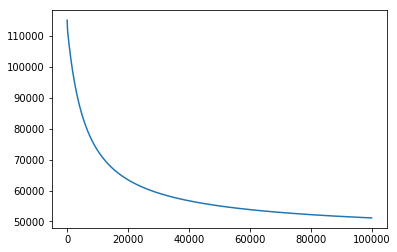

In [227]:
train_pred,cv_pred,test_pred = softmax_logistic_regression(X_train,y_train_OH,X_cv,y_cv_OH,X_test,y_test_OH,m=10,learning_rate=0.09,la=2,iterate=100000)

In [184]:

kmeans = KMeans(n_clusters=m, random_state=0).fit(X_train) # Cluster the data to create centroids (mean values) which will be used to compute gaussian kernals 
Mu = kmeans.cluster_centers_ #matrix containing the mean values of features for every data point in each cluster
print(Mu.shape)
BigSigma     = GenerateBigSigma(X_train.T, Mu, 100) # compute the covariance Matrix
TRAINING_PHI = GetPhiMatrix(X_train.T, Mu, BigSigma, 100) # Compute the Gaussian radial basis for training data.
TEST_PHI     = GetPhiMatrix(X_test.T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(X_cv.T, Mu, BigSigma, 100)


(5, 784)




  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 7/100000 [00:00<27:00, 61.69it/s]

  0%|          | 15/100000 [00:00<25:20, 65.75it/s]

  0%|          | 23/100000 [00:00<24:03, 69.28it/s]

  0%|          | 31/100000 [00:00<23:13, 71.76it/s]

  0%|          | 40/100000 [00:00<22:01, 75.65it/s]

  0%|          | 48/100000 [00:00<21:47, 76.46it/s]

  0%|          | 57/100000 [00:00<21:14, 78.43it/s]

  0%|          | 66/100000 [00:00<20:44, 80.28it/s]

  0%|          | 74/100000 [00:00<20:57, 79.44it/s]

  0%|          | 83/100000 [00:01<20:53, 79.69it/s]

  0%|          | 91/100000 [00:01<20:53, 79.70it/s]

  0%|          | 99/100000 [00:01<21:15, 78.31it/s]

  0%|          | 108/100000 [00:01<20:55, 79.55it/s]

  0%|          | 117/100000 [00:01<20:28, 81.29it/s]

  0%|          | 126/100000 [00:01<20:09, 82.58it/s]

  0%|          | 135/100000 [00:01<20:04, 82.94it/s]

  0%|          | 144/100000 [00:01<20:37, 80.68it/s]

  0%|          | 153/100000 [00:01<20:40, 80.51it

  2%|▏         | 2343/100000 [00:29<19:40, 82.75it/s]

  2%|▏         | 2352/100000 [00:29<19:51, 81.98it/s]

  2%|▏         | 2361/100000 [00:29<19:42, 82.55it/s]

  2%|▏         | 2370/100000 [00:29<19:27, 83.63it/s]

  2%|▏         | 2379/100000 [00:29<19:18, 84.26it/s]

  2%|▏         | 2388/100000 [00:29<19:09, 84.89it/s]

  2%|▏         | 2397/100000 [00:29<19:08, 85.00it/s]

  2%|▏         | 2406/100000 [00:29<18:57, 85.76it/s]

  2%|▏         | 2415/100000 [00:30<18:54, 86.03it/s]

  2%|▏         | 2424/100000 [00:30<18:48, 86.49it/s]

  2%|▏         | 2433/100000 [00:30<18:53, 86.07it/s]

  2%|▏         | 2442/100000 [00:30<18:55, 85.90it/s]

  2%|▏         | 2451/100000 [00:30<19:10, 84.82it/s]

  2%|▏         | 2460/100000 [00:30<19:43, 82.43it/s]

  2%|▏         | 2469/100000 [00:30<19:46, 82.23it/s]

  2%|▏         | 2478/100000 [00:30<19:34, 83.04it/s]

  2%|▏         | 2487/100000 [00:30<19:35, 82.94it/s]

  2%|▏         | 2496/100000 [00:31<19:29, 83.40it/s]

  3%|▎    

  5%|▍         | 4663/100000 [00:57<19:08, 83.02it/s]

  5%|▍         | 4672/100000 [00:58<19:05, 83.22it/s]

  5%|▍         | 4681/100000 [00:58<18:50, 84.30it/s]

  5%|▍         | 4690/100000 [00:58<18:38, 85.21it/s]

  5%|▍         | 4699/100000 [00:58<18:37, 85.31it/s]

  5%|▍         | 4708/100000 [00:58<18:27, 86.04it/s]

  5%|▍         | 4717/100000 [00:58<18:24, 86.29it/s]

  5%|▍         | 4726/100000 [00:58<18:24, 86.25it/s]

  5%|▍         | 4735/100000 [00:58<18:28, 85.96it/s]

  5%|▍         | 4744/100000 [00:58<18:19, 86.63it/s]

  5%|▍         | 4753/100000 [00:59<18:18, 86.74it/s]

  5%|▍         | 4762/100000 [00:59<18:17, 86.78it/s]

  5%|▍         | 4771/100000 [00:59<18:17, 86.75it/s]

  5%|▍         | 4780/100000 [00:59<18:09, 87.44it/s]

  5%|▍         | 4789/100000 [00:59<18:14, 86.96it/s]

  5%|▍         | 4798/100000 [00:59<18:13, 87.03it/s]

  5%|▍         | 4807/100000 [00:59<18:29, 85.78it/s]

  5%|▍         | 4816/100000 [00:59<18:23, 86.30it/s]

  5%|▍    

  7%|▋         | 7024/100000 [01:26<18:23, 84.29it/s]

  7%|▋         | 7033/100000 [01:26<18:30, 83.69it/s]

  7%|▋         | 7042/100000 [01:26<18:24, 84.14it/s]

  7%|▋         | 7051/100000 [01:26<18:12, 85.11it/s]

  7%|▋         | 7060/100000 [01:27<18:03, 85.75it/s]

  7%|▋         | 7069/100000 [01:27<18:02, 85.85it/s]

  7%|▋         | 7078/100000 [01:27<18:02, 85.83it/s]

  7%|▋         | 7087/100000 [01:27<18:05, 85.59it/s]

  7%|▋         | 7096/100000 [01:27<18:05, 85.56it/s]

  7%|▋         | 7105/100000 [01:27<18:03, 85.71it/s]

  7%|▋         | 7114/100000 [01:27<18:07, 85.39it/s]

  7%|▋         | 7123/100000 [01:27<18:10, 85.16it/s]

  7%|▋         | 7132/100000 [01:27<18:04, 85.64it/s]

  7%|▋         | 7141/100000 [01:28<18:02, 85.75it/s]

  7%|▋         | 7150/100000 [01:28<18:06, 85.47it/s]

  7%|▋         | 7159/100000 [01:28<17:58, 86.04it/s]

  7%|▋         | 7168/100000 [01:28<17:57, 86.17it/s]

  7%|▋         | 7177/100000 [01:28<18:15, 84.75it/s]

  7%|▋    

  9%|▉         | 9395/100000 [01:55<21:19, 70.84it/s]

  9%|▉         | 9403/100000 [01:55<21:28, 70.31it/s]

  9%|▉         | 9412/100000 [01:55<20:21, 74.17it/s]

  9%|▉         | 9421/100000 [01:55<19:43, 76.51it/s]

  9%|▉         | 9430/100000 [01:56<18:58, 79.54it/s]

  9%|▉         | 9439/100000 [01:56<18:29, 81.61it/s]

  9%|▉         | 9448/100000 [01:56<18:15, 82.68it/s]

  9%|▉         | 9457/100000 [01:56<18:01, 83.75it/s]

  9%|▉         | 9466/100000 [01:56<18:22, 82.14it/s]

  9%|▉         | 9475/100000 [01:56<18:05, 83.38it/s]

  9%|▉         | 9484/100000 [01:56<17:47, 84.81it/s]

  9%|▉         | 9493/100000 [01:56<17:45, 84.96it/s]

 10%|▉         | 9502/100000 [01:56<17:27, 86.40it/s]

 10%|▉         | 9511/100000 [01:57<17:49, 84.62it/s]

 10%|▉         | 9521/100000 [01:57<17:26, 86.44it/s]

 10%|▉         | 9530/100000 [01:57<17:25, 86.55it/s]

 10%|▉         | 9539/100000 [01:57<17:23, 86.70it/s]

 10%|▉         | 9548/100000 [01:57<17:35, 85.68it/s]

 10%|▉    

 12%|█▏        | 11771/100000 [02:24<17:42, 83.05it/s]

 12%|█▏        | 11780/100000 [02:24<17:45, 82.79it/s]

 12%|█▏        | 11789/100000 [02:24<17:35, 83.54it/s]

 12%|█▏        | 11798/100000 [02:24<17:38, 83.30it/s]

 12%|█▏        | 11807/100000 [02:24<17:31, 83.90it/s]

 12%|█▏        | 11816/100000 [02:24<17:30, 83.92it/s]

 12%|█▏        | 11825/100000 [02:24<17:27, 84.20it/s]

 12%|█▏        | 11834/100000 [02:25<17:26, 84.25it/s]

 12%|█▏        | 11843/100000 [02:25<17:29, 83.97it/s]

 12%|█▏        | 11852/100000 [02:25<17:20, 84.74it/s]

 12%|█▏        | 11861/100000 [02:25<17:18, 84.91it/s]

 12%|█▏        | 11870/100000 [02:25<17:14, 85.19it/s]

 12%|█▏        | 11879/100000 [02:25<17:14, 85.15it/s]

 12%|█▏        | 11888/100000 [02:25<17:22, 84.50it/s]

 12%|█▏        | 11897/100000 [02:25<17:22, 84.54it/s]

 12%|█▏        | 11906/100000 [02:25<17:08, 85.69it/s]

 12%|█▏        | 11915/100000 [02:25<17:01, 86.20it/s]

 12%|█▏        | 11924/100000 [02:26<17:00, 86.3

 14%|█▍        | 14122/100000 [02:52<17:04, 83.80it/s]

 14%|█▍        | 14131/100000 [02:52<17:33, 81.52it/s]

 14%|█▍        | 14140/100000 [02:52<17:26, 82.07it/s]

 14%|█▍        | 14149/100000 [02:52<17:06, 83.67it/s]

 14%|█▍        | 14158/100000 [02:53<16:50, 84.94it/s]

 14%|█▍        | 14167/100000 [02:53<16:49, 85.06it/s]

 14%|█▍        | 14176/100000 [02:53<16:55, 84.53it/s]

 14%|█▍        | 14185/100000 [02:53<16:56, 84.40it/s]

 14%|█▍        | 14194/100000 [02:53<16:59, 84.13it/s]

 14%|█▍        | 14203/100000 [02:53<16:55, 84.49it/s]

 14%|█▍        | 14212/100000 [02:53<17:00, 84.08it/s]

 14%|█▍        | 14221/100000 [02:53<17:14, 82.94it/s]

 14%|█▍        | 14230/100000 [02:53<17:05, 83.66it/s]

 14%|█▍        | 14239/100000 [02:53<16:52, 84.68it/s]

 14%|█▍        | 14248/100000 [02:54<16:45, 85.27it/s]

 14%|█▍        | 14257/100000 [02:54<16:48, 85.01it/s]

 14%|█▍        | 14266/100000 [02:54<17:06, 83.48it/s]

 14%|█▍        | 14275/100000 [02:54<16:45, 85.2

 16%|█▋        | 16466/100000 [03:21<19:02, 73.11it/s]

 16%|█▋        | 16474/100000 [03:21<19:03, 73.04it/s]

 16%|█▋        | 16482/100000 [03:21<18:59, 73.31it/s]

 16%|█▋        | 16490/100000 [03:21<19:15, 72.25it/s]

 16%|█▋        | 16498/100000 [03:21<18:54, 73.59it/s]

 17%|█▋        | 16506/100000 [03:21<18:49, 73.94it/s]

 17%|█▋        | 16514/100000 [03:21<19:06, 72.83it/s]

 17%|█▋        | 16522/100000 [03:21<18:54, 73.59it/s]

 17%|█▋        | 16530/100000 [03:22<18:43, 74.30it/s]

 17%|█▋        | 16538/100000 [03:22<18:27, 75.37it/s]

 17%|█▋        | 16546/100000 [03:22<18:44, 74.20it/s]

 17%|█▋        | 16554/100000 [03:22<19:37, 70.89it/s]

 17%|█▋        | 16562/100000 [03:22<19:22, 71.80it/s]

 17%|█▋        | 16570/100000 [03:22<19:04, 72.93it/s]

 17%|█▋        | 16578/100000 [03:22<18:41, 74.38it/s]

 17%|█▋        | 16586/100000 [03:22<18:30, 75.08it/s]

 17%|█▋        | 16594/100000 [03:22<18:27, 75.29it/s]

 17%|█▋        | 16602/100000 [03:22<18:12, 76.3

 19%|█▉        | 18787/100000 [03:49<15:42, 86.15it/s]

 19%|█▉        | 18796/100000 [03:49<15:43, 86.08it/s]

 19%|█▉        | 18805/100000 [03:49<15:32, 87.09it/s]

 19%|█▉        | 18815/100000 [03:49<15:17, 88.48it/s]

 19%|█▉        | 18825/100000 [03:50<15:06, 89.59it/s]

 19%|█▉        | 18835/100000 [03:50<14:59, 90.27it/s]

 19%|█▉        | 18845/100000 [03:50<14:56, 90.52it/s]

 19%|█▉        | 18855/100000 [03:50<14:48, 91.31it/s]

 19%|█▉        | 18865/100000 [03:50<14:51, 90.96it/s]

 19%|█▉        | 18875/100000 [03:50<14:46, 91.56it/s]

 19%|█▉        | 18885/100000 [03:50<14:46, 91.54it/s]

 19%|█▉        | 18895/100000 [03:50<14:48, 91.24it/s]

 19%|█▉        | 18905/100000 [03:50<14:51, 90.95it/s]

 19%|█▉        | 18915/100000 [03:51<14:51, 90.96it/s]

 19%|█▉        | 18925/100000 [03:51<14:44, 91.66it/s]

 19%|█▉        | 18935/100000 [03:51<14:46, 91.42it/s]

 19%|█▉        | 18945/100000 [03:51<14:43, 91.71it/s]

 19%|█▉        | 18955/100000 [03:51<14:50, 91.0

 21%|██▏       | 21314/100000 [04:18<15:17, 85.79it/s]

 21%|██▏       | 21323/100000 [04:18<15:20, 85.52it/s]

 21%|██▏       | 21333/100000 [04:18<14:58, 87.58it/s]

 21%|██▏       | 21343/100000 [04:18<14:46, 88.70it/s]

 21%|██▏       | 21353/100000 [04:18<14:33, 90.04it/s]

 21%|██▏       | 21363/100000 [04:18<14:31, 90.25it/s]

 21%|██▏       | 21373/100000 [04:19<14:20, 91.33it/s]

 21%|██▏       | 21383/100000 [04:19<14:22, 91.17it/s]

 21%|██▏       | 21393/100000 [04:19<14:23, 91.04it/s]

 21%|██▏       | 21403/100000 [04:19<14:19, 91.48it/s]

 21%|██▏       | 21413/100000 [04:19<14:23, 91.01it/s]

 21%|██▏       | 21423/100000 [04:19<14:20, 91.26it/s]

 21%|██▏       | 21433/100000 [04:19<14:25, 90.78it/s]

 21%|██▏       | 21443/100000 [04:19<14:21, 91.22it/s]

 21%|██▏       | 21453/100000 [04:19<14:18, 91.47it/s]

 21%|██▏       | 21463/100000 [04:20<14:21, 91.13it/s]

 21%|██▏       | 21473/100000 [04:20<14:16, 91.73it/s]

 21%|██▏       | 21483/100000 [04:20<14:11, 92.2

 24%|██▍       | 23875/100000 [04:46<14:18, 88.64it/s]

 24%|██▍       | 23884/100000 [04:47<14:28, 87.63it/s]

 24%|██▍       | 23893/100000 [04:47<14:22, 88.22it/s]

 24%|██▍       | 23903/100000 [04:47<14:09, 89.53it/s]

 24%|██▍       | 23913/100000 [04:47<14:01, 90.36it/s]

 24%|██▍       | 23923/100000 [04:47<14:02, 90.33it/s]

 24%|██▍       | 23933/100000 [04:47<13:54, 91.11it/s]

 24%|██▍       | 23943/100000 [04:47<13:45, 92.12it/s]

 24%|██▍       | 23953/100000 [04:47<13:39, 92.82it/s]

 24%|██▍       | 23963/100000 [04:47<13:44, 92.27it/s]

 24%|██▍       | 23973/100000 [04:47<13:40, 92.67it/s]

 24%|██▍       | 23983/100000 [04:48<13:46, 91.95it/s]

 24%|██▍       | 23993/100000 [04:48<13:54, 91.06it/s]

 24%|██▍       | 24003/100000 [04:48<13:52, 91.29it/s]

 24%|██▍       | 24013/100000 [04:48<13:54, 91.03it/s]

 24%|██▍       | 24023/100000 [04:48<13:47, 91.79it/s]

 24%|██▍       | 24033/100000 [04:48<13:54, 90.98it/s]

 24%|██▍       | 24043/100000 [04:48<13:53, 91.1

 26%|██▋       | 26366/100000 [05:15<14:24, 85.17it/s]

 26%|██▋       | 26375/100000 [05:15<14:35, 84.12it/s]

 26%|██▋       | 26384/100000 [05:15<14:27, 84.83it/s]

 26%|██▋       | 26393/100000 [05:15<14:29, 84.68it/s]

 26%|██▋       | 26402/100000 [05:15<14:21, 85.47it/s]

 26%|██▋       | 26411/100000 [05:15<14:18, 85.74it/s]

 26%|██▋       | 26420/100000 [05:15<14:14, 86.11it/s]

 26%|██▋       | 26429/100000 [05:15<14:18, 85.72it/s]

 26%|██▋       | 26438/100000 [05:16<14:13, 86.22it/s]

 26%|██▋       | 26447/100000 [05:16<14:13, 86.15it/s]

 26%|██▋       | 26456/100000 [05:16<14:13, 86.17it/s]

 26%|██▋       | 26465/100000 [05:16<14:17, 85.73it/s]

 26%|██▋       | 26474/100000 [05:16<14:12, 86.22it/s]

 26%|██▋       | 26483/100000 [05:16<14:14, 86.01it/s]

 26%|██▋       | 26492/100000 [05:16<14:20, 85.46it/s]

 27%|██▋       | 26501/100000 [05:16<14:21, 85.33it/s]

 27%|██▋       | 26510/100000 [05:16<14:22, 85.19it/s]

 27%|██▋       | 26519/100000 [05:16<14:28, 84.6

 29%|██▊       | 28743/100000 [05:43<14:01, 84.64it/s]

 29%|██▉       | 28752/100000 [05:43<14:06, 84.20it/s]

 29%|██▉       | 28761/100000 [05:43<14:04, 84.39it/s]

 29%|██▉       | 28770/100000 [05:43<13:57, 85.08it/s]

 29%|██▉       | 28779/100000 [05:43<14:08, 83.98it/s]

 29%|██▉       | 28788/100000 [05:43<14:02, 84.50it/s]

 29%|██▉       | 28797/100000 [05:43<14:01, 84.61it/s]

 29%|██▉       | 28806/100000 [05:43<13:57, 84.98it/s]

 29%|██▉       | 28815/100000 [05:43<14:00, 84.72it/s]

 29%|██▉       | 28824/100000 [05:43<13:54, 85.33it/s]

 29%|██▉       | 28833/100000 [05:44<13:56, 85.06it/s]

 29%|██▉       | 28842/100000 [05:44<13:52, 85.52it/s]

 29%|██▉       | 28851/100000 [05:44<13:50, 85.70it/s]

 29%|██▉       | 28860/100000 [05:44<13:54, 85.27it/s]

 29%|██▉       | 28869/100000 [05:44<13:57, 84.92it/s]

 29%|██▉       | 28878/100000 [05:44<13:45, 86.19it/s]

 29%|██▉       | 28887/100000 [05:44<13:41, 86.57it/s]

 29%|██▉       | 28896/100000 [05:44<13:44, 86.2

 31%|███       | 31121/100000 [06:10<13:30, 84.97it/s]

 31%|███       | 31130/100000 [06:11<13:41, 83.86it/s]

 31%|███       | 31139/100000 [06:11<13:33, 84.67it/s]

 31%|███       | 31148/100000 [06:11<13:23, 85.64it/s]

 31%|███       | 31157/100000 [06:11<13:21, 85.91it/s]

 31%|███       | 31166/100000 [06:11<13:22, 85.79it/s]

 31%|███       | 31175/100000 [06:11<13:23, 85.66it/s]

 31%|███       | 31184/100000 [06:11<13:14, 86.64it/s]

 31%|███       | 31193/100000 [06:11<13:10, 87.00it/s]

 31%|███       | 31202/100000 [06:11<13:11, 86.94it/s]

 31%|███       | 31211/100000 [06:11<13:20, 85.92it/s]

 31%|███       | 31220/100000 [06:12<13:21, 85.85it/s]

 31%|███       | 31229/100000 [06:12<13:21, 85.82it/s]

 31%|███       | 31238/100000 [06:12<13:24, 85.48it/s]

 31%|███       | 31247/100000 [06:12<13:27, 85.19it/s]

 31%|███▏      | 31256/100000 [06:12<13:26, 85.20it/s]

 31%|███▏      | 31265/100000 [06:12<13:28, 85.04it/s]

 31%|███▏      | 31274/100000 [06:12<13:22, 85.6

 33%|███▎      | 33490/100000 [06:39<13:28, 82.30it/s]

 33%|███▎      | 33499/100000 [06:39<13:56, 79.53it/s]

 34%|███▎      | 33508/100000 [06:39<13:45, 80.56it/s]

 34%|███▎      | 33517/100000 [06:39<13:39, 81.13it/s]

 34%|███▎      | 33526/100000 [06:39<13:31, 81.92it/s]

 34%|███▎      | 33535/100000 [06:39<14:00, 79.12it/s]

 34%|███▎      | 33543/100000 [06:39<14:05, 78.64it/s]

 34%|███▎      | 33552/100000 [06:39<13:50, 79.97it/s]

 34%|███▎      | 33561/100000 [06:39<13:44, 80.54it/s]

 34%|███▎      | 33570/100000 [06:40<13:38, 81.20it/s]

 34%|███▎      | 33579/100000 [06:40<13:42, 80.75it/s]

 34%|███▎      | 33588/100000 [06:40<13:39, 81.04it/s]

 34%|███▎      | 33597/100000 [06:40<13:31, 81.78it/s]

 34%|███▎      | 33606/100000 [06:40<13:24, 82.51it/s]

 34%|███▎      | 33615/100000 [06:40<13:27, 82.20it/s]

 34%|███▎      | 33624/100000 [06:40<13:33, 81.56it/s]

 34%|███▎      | 33633/100000 [06:40<13:30, 81.92it/s]

 34%|███▎      | 33642/100000 [06:40<13:39, 81.0

 36%|███▌      | 35757/100000 [07:07<13:33, 78.99it/s]

 36%|███▌      | 35765/100000 [07:07<13:36, 78.68it/s]

 36%|███▌      | 35774/100000 [07:07<13:15, 80.74it/s]

 36%|███▌      | 35783/100000 [07:08<13:09, 81.38it/s]

 36%|███▌      | 35792/100000 [07:08<12:53, 83.02it/s]

 36%|███▌      | 35801/100000 [07:08<12:46, 83.77it/s]

 36%|███▌      | 35810/100000 [07:08<12:51, 83.16it/s]

 36%|███▌      | 35819/100000 [07:08<12:42, 84.13it/s]

 36%|███▌      | 35828/100000 [07:08<12:45, 83.81it/s]

 36%|███▌      | 35837/100000 [07:08<12:43, 84.04it/s]

 36%|███▌      | 35846/100000 [07:08<12:36, 84.78it/s]

 36%|███▌      | 35855/100000 [07:08<12:35, 84.90it/s]

 36%|███▌      | 35864/100000 [07:08<12:36, 84.77it/s]

 36%|███▌      | 35873/100000 [07:09<12:31, 85.34it/s]

 36%|███▌      | 35882/100000 [07:09<12:28, 85.64it/s]

 36%|███▌      | 35891/100000 [07:09<12:32, 85.17it/s]

 36%|███▌      | 35900/100000 [07:09<12:29, 85.55it/s]

 36%|███▌      | 35909/100000 [07:09<12:33, 85.0

 38%|███▊      | 38132/100000 [07:35<12:12, 84.42it/s]

 38%|███▊      | 38141/100000 [07:35<12:16, 83.99it/s]

 38%|███▊      | 38150/100000 [07:35<12:24, 83.05it/s]

 38%|███▊      | 38159/100000 [07:36<12:28, 82.61it/s]

 38%|███▊      | 38168/100000 [07:36<12:19, 83.58it/s]

 38%|███▊      | 38177/100000 [07:36<12:15, 84.11it/s]

 38%|███▊      | 38186/100000 [07:36<12:06, 85.14it/s]

 38%|███▊      | 38195/100000 [07:36<11:57, 86.17it/s]

 38%|███▊      | 38204/100000 [07:36<11:51, 86.90it/s]

 38%|███▊      | 38213/100000 [07:36<11:56, 86.28it/s]

 38%|███▊      | 38222/100000 [07:36<12:00, 85.79it/s]

 38%|███▊      | 38231/100000 [07:36<11:57, 86.03it/s]

 38%|███▊      | 38240/100000 [07:36<11:57, 86.11it/s]

 38%|███▊      | 38249/100000 [07:37<12:03, 85.36it/s]

 38%|███▊      | 38258/100000 [07:37<11:57, 86.01it/s]

 38%|███▊      | 38267/100000 [07:37<11:54, 86.45it/s]

 38%|███▊      | 38276/100000 [07:37<11:54, 86.42it/s]

 38%|███▊      | 38285/100000 [07:37<12:00, 85.6

 41%|████      | 40504/100000 [08:03<11:33, 85.79it/s]

 41%|████      | 40513/100000 [08:03<11:42, 84.70it/s]

 41%|████      | 40522/100000 [08:03<11:37, 85.30it/s]

 41%|████      | 40531/100000 [08:04<11:35, 85.53it/s]

 41%|████      | 40540/100000 [08:04<11:31, 86.04it/s]

 41%|████      | 40549/100000 [08:04<11:30, 86.11it/s]

 41%|████      | 40558/100000 [08:04<11:30, 86.03it/s]

 41%|████      | 40567/100000 [08:04<11:45, 84.25it/s]

 41%|████      | 40576/100000 [08:04<11:42, 84.62it/s]

 41%|████      | 40585/100000 [08:04<11:40, 84.80it/s]

 41%|████      | 40594/100000 [08:04<11:35, 85.45it/s]

 41%|████      | 40603/100000 [08:04<11:30, 85.99it/s]

 41%|████      | 40612/100000 [08:04<11:28, 86.20it/s]

 41%|████      | 40621/100000 [08:05<11:31, 85.83it/s]

 41%|████      | 40630/100000 [08:05<11:27, 86.30it/s]

 41%|████      | 40639/100000 [08:05<11:19, 87.36it/s]

 41%|████      | 40648/100000 [08:05<11:18, 87.41it/s]

 41%|████      | 40657/100000 [08:05<11:26, 86.4

 43%|████▎     | 42880/100000 [08:31<11:11, 85.01it/s]

 43%|████▎     | 42889/100000 [08:31<11:16, 84.38it/s]

 43%|████▎     | 42898/100000 [08:31<11:09, 85.27it/s]

 43%|████▎     | 42907/100000 [08:31<11:06, 85.65it/s]

 43%|████▎     | 42916/100000 [08:32<11:07, 85.54it/s]

 43%|████▎     | 42925/100000 [08:32<11:01, 86.23it/s]

 43%|████▎     | 42934/100000 [08:32<10:57, 86.79it/s]

 43%|████▎     | 42943/100000 [08:32<10:55, 87.02it/s]

 43%|████▎     | 42952/100000 [08:32<10:58, 86.62it/s]

 43%|████▎     | 42961/100000 [08:32<11:05, 85.73it/s]

 43%|████▎     | 42970/100000 [08:32<11:02, 86.08it/s]

 43%|████▎     | 42979/100000 [08:32<11:00, 86.27it/s]

 43%|████▎     | 42988/100000 [08:32<11:06, 85.54it/s]

 43%|████▎     | 42997/100000 [08:33<11:08, 85.33it/s]

 43%|████▎     | 43006/100000 [08:33<11:04, 85.80it/s]

 43%|████▎     | 43015/100000 [08:33<11:04, 85.71it/s]

 43%|████▎     | 43024/100000 [08:33<11:06, 85.44it/s]

 43%|████▎     | 43033/100000 [08:33<11:12, 84.7

 45%|████▌     | 45235/100000 [08:59<10:44, 85.03it/s]

 45%|████▌     | 45244/100000 [08:59<10:46, 84.65it/s]

 45%|████▌     | 45253/100000 [09:00<10:42, 85.26it/s]

 45%|████▌     | 45262/100000 [09:00<10:37, 85.83it/s]

 45%|████▌     | 45271/100000 [09:00<10:37, 85.78it/s]

 45%|████▌     | 45280/100000 [09:00<10:39, 85.52it/s]

 45%|████▌     | 45289/100000 [09:00<10:35, 86.08it/s]

 45%|████▌     | 45298/100000 [09:00<10:33, 86.40it/s]

 45%|████▌     | 45307/100000 [09:00<10:42, 85.14it/s]

 45%|████▌     | 45316/100000 [09:00<10:36, 85.85it/s]

 45%|████▌     | 45325/100000 [09:00<10:36, 85.93it/s]

 45%|████▌     | 45334/100000 [09:00<10:34, 86.13it/s]

 45%|████▌     | 45343/100000 [09:01<10:39, 85.44it/s]

 45%|████▌     | 45352/100000 [09:01<10:34, 86.08it/s]

 45%|████▌     | 45361/100000 [09:01<10:35, 85.91it/s]

 45%|████▌     | 45370/100000 [09:01<10:41, 85.19it/s]

 45%|████▌     | 45379/100000 [09:01<10:38, 85.50it/s]

 45%|████▌     | 45388/100000 [09:01<10:42, 84.9

 48%|████▊     | 47611/100000 [09:27<10:20, 84.45it/s]

 48%|████▊     | 47620/100000 [09:27<10:23, 84.01it/s]

 48%|████▊     | 47629/100000 [09:27<10:20, 84.42it/s]

 48%|████▊     | 47638/100000 [09:28<10:12, 85.47it/s]

 48%|████▊     | 47647/100000 [09:28<10:10, 85.79it/s]

 48%|████▊     | 47656/100000 [09:28<10:10, 85.68it/s]

 48%|████▊     | 47665/100000 [09:28<10:11, 85.52it/s]

 48%|████▊     | 47674/100000 [09:28<10:14, 85.09it/s]

 48%|████▊     | 47683/100000 [09:28<10:13, 85.33it/s]

 48%|████▊     | 47692/100000 [09:28<10:09, 85.85it/s]

 48%|████▊     | 47701/100000 [09:28<10:09, 85.85it/s]

 48%|████▊     | 47710/100000 [09:28<10:08, 85.98it/s]

 48%|████▊     | 47719/100000 [09:29<10:12, 85.29it/s]

 48%|████▊     | 47728/100000 [09:29<10:10, 85.59it/s]

 48%|████▊     | 47737/100000 [09:29<10:12, 85.27it/s]

 48%|████▊     | 47746/100000 [09:29<10:11, 85.39it/s]

 48%|████▊     | 47755/100000 [09:29<10:09, 85.73it/s]

 48%|████▊     | 47764/100000 [09:29<10:09, 85.6

 50%|████▉     | 49987/100000 [09:55<09:51, 84.57it/s]

 50%|████▉     | 49996/100000 [09:55<09:54, 84.07it/s]

 50%|█████     | 50005/100000 [09:55<09:47, 85.10it/s]

 50%|█████     | 50014/100000 [09:55<09:46, 85.29it/s]

 50%|█████     | 50023/100000 [09:56<09:46, 85.16it/s]

 50%|█████     | 50032/100000 [09:56<09:42, 85.73it/s]

 50%|█████     | 50041/100000 [09:56<09:39, 86.24it/s]

 50%|█████     | 50050/100000 [09:56<09:36, 86.67it/s]

 50%|█████     | 50059/100000 [09:56<09:36, 86.57it/s]

 50%|█████     | 50068/100000 [09:56<09:41, 85.80it/s]

 50%|█████     | 50077/100000 [09:56<09:42, 85.70it/s]

 50%|█████     | 50086/100000 [09:56<09:40, 86.01it/s]

 50%|█████     | 50095/100000 [09:56<09:44, 85.41it/s]

 50%|█████     | 50104/100000 [09:57<09:41, 85.77it/s]

 50%|█████     | 50113/100000 [09:57<09:43, 85.50it/s]

 50%|█████     | 50122/100000 [09:57<09:45, 85.19it/s]

 50%|█████     | 50131/100000 [09:57<09:39, 86.09it/s]

 50%|█████     | 50140/100000 [09:57<09:36, 86.5

 52%|█████▏    | 52363/100000 [10:23<09:28, 83.77it/s]

 52%|█████▏    | 52372/100000 [10:23<09:32, 83.18it/s]

 52%|█████▏    | 52381/100000 [10:23<09:28, 83.70it/s]

 52%|█████▏    | 52390/100000 [10:23<09:26, 84.10it/s]

 52%|█████▏    | 52399/100000 [10:24<09:24, 84.29it/s]

 52%|█████▏    | 52408/100000 [10:24<09:21, 84.76it/s]

 52%|█████▏    | 52417/100000 [10:24<09:22, 84.58it/s]

 52%|█████▏    | 52426/100000 [10:24<09:20, 84.85it/s]

 52%|█████▏    | 52435/100000 [10:24<09:21, 84.77it/s]

 52%|█████▏    | 52444/100000 [10:24<09:19, 84.94it/s]

 52%|█████▏    | 52453/100000 [10:24<09:20, 84.89it/s]

 52%|█████▏    | 52462/100000 [10:24<09:14, 85.78it/s]

 52%|█████▏    | 52471/100000 [10:24<09:15, 85.62it/s]

 52%|█████▏    | 52480/100000 [10:25<09:22, 84.51it/s]

 52%|█████▏    | 52489/100000 [10:25<09:24, 84.16it/s]

 52%|█████▏    | 52498/100000 [10:25<09:22, 84.44it/s]

 53%|█████▎    | 52507/100000 [10:25<09:15, 85.46it/s]

 53%|█████▎    | 52516/100000 [10:25<09:12, 85.8

 55%|█████▍    | 54731/100000 [10:51<08:58, 84.11it/s]

 55%|█████▍    | 54740/100000 [10:51<08:55, 84.54it/s]

 55%|█████▍    | 54749/100000 [10:52<08:50, 85.24it/s]

 55%|█████▍    | 54758/100000 [10:52<08:45, 86.16it/s]

 55%|█████▍    | 54767/100000 [10:52<08:43, 86.37it/s]

 55%|█████▍    | 54776/100000 [10:52<08:47, 85.77it/s]

 55%|█████▍    | 54785/100000 [10:52<08:47, 85.72it/s]

 55%|█████▍    | 54794/100000 [10:52<08:45, 85.97it/s]

 55%|█████▍    | 54803/100000 [10:52<08:46, 85.80it/s]

 55%|█████▍    | 54812/100000 [10:52<08:47, 85.64it/s]

 55%|█████▍    | 54821/100000 [10:52<08:44, 86.13it/s]

 55%|█████▍    | 54830/100000 [10:53<08:42, 86.46it/s]

 55%|█████▍    | 54839/100000 [10:53<08:44, 86.11it/s]

 55%|█████▍    | 54848/100000 [10:53<08:44, 86.15it/s]

 55%|█████▍    | 54857/100000 [10:53<08:45, 85.94it/s]

 55%|█████▍    | 54866/100000 [10:53<08:45, 85.91it/s]

 55%|█████▍    | 54875/100000 [10:53<08:45, 85.85it/s]

 55%|█████▍    | 54884/100000 [10:53<08:46, 85.7

 57%|█████▋    | 57108/100000 [11:19<08:23, 85.20it/s]

 57%|█████▋    | 57117/100000 [11:19<08:29, 84.14it/s]

 57%|█████▋    | 57126/100000 [11:19<08:26, 84.70it/s]

 57%|█████▋    | 57135/100000 [11:20<08:26, 84.60it/s]

 57%|█████▋    | 57144/100000 [11:20<08:21, 85.39it/s]

 57%|█████▋    | 57153/100000 [11:20<08:21, 85.44it/s]

 57%|█████▋    | 57162/100000 [11:20<08:24, 84.91it/s]

 57%|█████▋    | 57171/100000 [11:20<08:23, 85.04it/s]

 57%|█████▋    | 57180/100000 [11:20<08:25, 84.70it/s]

 57%|█████▋    | 57189/100000 [11:20<08:25, 84.66it/s]

 57%|█████▋    | 57198/100000 [11:20<08:19, 85.66it/s]

 57%|█████▋    | 57207/100000 [11:20<08:21, 85.37it/s]

 57%|█████▋    | 57216/100000 [11:21<08:19, 85.63it/s]

 57%|█████▋    | 57225/100000 [11:21<08:18, 85.76it/s]

 57%|█████▋    | 57234/100000 [11:21<08:17, 86.02it/s]

 57%|█████▋    | 57243/100000 [11:21<08:17, 85.92it/s]

 57%|█████▋    | 57252/100000 [11:21<08:18, 85.75it/s]

 57%|█████▋    | 57261/100000 [11:21<08:12, 86.8

 59%|█████▉    | 59485/100000 [11:47<08:06, 83.36it/s]

 59%|█████▉    | 59494/100000 [11:47<08:06, 83.18it/s]

 60%|█████▉    | 59503/100000 [11:47<08:06, 83.28it/s]

 60%|█████▉    | 59512/100000 [11:48<08:02, 83.97it/s]

 60%|█████▉    | 59521/100000 [11:48<07:59, 84.40it/s]

 60%|█████▉    | 59530/100000 [11:48<07:57, 84.67it/s]

 60%|█████▉    | 59539/100000 [11:48<07:58, 84.62it/s]

 60%|█████▉    | 59548/100000 [11:48<07:54, 85.20it/s]

 60%|█████▉    | 59557/100000 [11:48<07:52, 85.55it/s]

 60%|█████▉    | 59566/100000 [11:48<07:51, 85.73it/s]

 60%|█████▉    | 59575/100000 [11:48<07:52, 85.57it/s]

 60%|█████▉    | 59584/100000 [11:48<07:48, 86.18it/s]

 60%|█████▉    | 59593/100000 [11:49<07:48, 86.22it/s]

 60%|█████▉    | 59602/100000 [11:49<07:48, 86.14it/s]

 60%|█████▉    | 59611/100000 [11:49<07:51, 85.68it/s]

 60%|█████▉    | 59620/100000 [11:49<07:49, 85.96it/s]

 60%|█████▉    | 59629/100000 [11:49<07:49, 85.94it/s]

 60%|█████▉    | 59638/100000 [11:49<07:52, 85.4

 62%|██████▏   | 61862/100000 [12:15<07:28, 85.10it/s]

 62%|██████▏   | 61871/100000 [12:15<07:30, 84.70it/s]

 62%|██████▏   | 61880/100000 [12:15<07:25, 85.54it/s]

 62%|██████▏   | 61889/100000 [12:16<07:24, 85.74it/s]

 62%|██████▏   | 61898/100000 [12:16<07:23, 85.85it/s]

 62%|██████▏   | 61907/100000 [12:16<07:25, 85.50it/s]

 62%|██████▏   | 61916/100000 [12:16<07:22, 86.14it/s]

 62%|██████▏   | 61925/100000 [12:16<07:21, 86.28it/s]

 62%|██████▏   | 61934/100000 [12:16<07:21, 86.13it/s]

 62%|██████▏   | 61943/100000 [12:16<07:18, 86.75it/s]

 62%|██████▏   | 61952/100000 [12:16<07:17, 86.90it/s]

 62%|██████▏   | 61961/100000 [12:16<07:18, 86.76it/s]

 62%|██████▏   | 61970/100000 [12:16<07:17, 86.90it/s]

 62%|██████▏   | 61979/100000 [12:17<07:19, 86.55it/s]

 62%|██████▏   | 61988/100000 [12:17<07:22, 85.89it/s]

 62%|██████▏   | 61997/100000 [12:17<07:22, 85.94it/s]

 62%|██████▏   | 62006/100000 [12:17<07:24, 85.57it/s]

 62%|██████▏   | 62015/100000 [12:17<07:23, 85.5

 64%|██████▍   | 64224/100000 [12:43<06:59, 85.38it/s]

 64%|██████▍   | 64233/100000 [12:44<07:05, 84.09it/s]

 64%|██████▍   | 64242/100000 [12:44<07:03, 84.47it/s]

 64%|██████▍   | 64251/100000 [12:44<06:58, 85.34it/s]

 64%|██████▍   | 64260/100000 [12:44<06:57, 85.54it/s]

 64%|██████▍   | 64269/100000 [12:44<06:57, 85.50it/s]

 64%|██████▍   | 64278/100000 [12:44<06:58, 85.36it/s]

 64%|██████▍   | 64287/100000 [12:44<06:56, 85.72it/s]

 64%|██████▍   | 64296/100000 [12:44<06:59, 85.07it/s]

 64%|██████▍   | 64305/100000 [12:44<06:57, 85.57it/s]

 64%|██████▍   | 64314/100000 [12:44<06:52, 86.54it/s]

 64%|██████▍   | 64323/100000 [12:45<06:51, 86.65it/s]

 64%|██████▍   | 64332/100000 [12:45<06:52, 86.43it/s]

 64%|██████▍   | 64341/100000 [12:45<06:55, 85.88it/s]

 64%|██████▍   | 64350/100000 [12:45<06:52, 86.36it/s]

 64%|██████▍   | 64359/100000 [12:45<06:53, 86.21it/s]

 64%|██████▍   | 64368/100000 [12:45<06:56, 85.56it/s]

 64%|██████▍   | 64377/100000 [12:45<06:55, 85.6

 67%|██████▋   | 66594/100000 [13:11<06:32, 85.17it/s]

 67%|██████▋   | 66603/100000 [13:11<06:36, 84.31it/s]

 67%|██████▋   | 66612/100000 [13:12<06:31, 85.23it/s]

 67%|██████▋   | 66621/100000 [13:12<06:28, 85.88it/s]

 67%|██████▋   | 66630/100000 [13:12<06:30, 85.55it/s]

 67%|██████▋   | 66639/100000 [13:12<06:30, 85.37it/s]

 67%|██████▋   | 66648/100000 [13:12<06:28, 85.89it/s]

 67%|██████▋   | 66657/100000 [13:12<06:28, 85.91it/s]

 67%|██████▋   | 66666/100000 [13:12<06:35, 84.23it/s]

 67%|██████▋   | 66675/100000 [13:12<06:35, 84.30it/s]

 67%|██████▋   | 66684/100000 [13:12<06:35, 84.22it/s]

 67%|██████▋   | 66693/100000 [13:13<06:31, 85.10it/s]

 67%|██████▋   | 66702/100000 [13:13<06:29, 85.58it/s]

 67%|██████▋   | 66711/100000 [13:13<06:32, 84.87it/s]

 67%|██████▋   | 66720/100000 [13:13<06:32, 84.77it/s]

 67%|██████▋   | 66729/100000 [13:13<06:30, 85.30it/s]

 67%|██████▋   | 66738/100000 [13:13<06:28, 85.70it/s]

 67%|██████▋   | 66747/100000 [13:13<06:32, 84.6

 69%|██████▉   | 68970/100000 [13:39<06:05, 85.01it/s]

 69%|██████▉   | 68979/100000 [13:39<06:07, 84.37it/s]

 69%|██████▉   | 68988/100000 [13:40<06:06, 84.61it/s]

 69%|██████▉   | 68997/100000 [13:40<06:07, 84.42it/s]

 69%|██████▉   | 69006/100000 [13:40<06:10, 83.61it/s]

 69%|██████▉   | 69015/100000 [13:40<06:07, 84.36it/s]

 69%|██████▉   | 69024/100000 [13:40<06:07, 84.27it/s]

 69%|██████▉   | 69033/100000 [13:40<06:08, 84.07it/s]

 69%|██████▉   | 69042/100000 [13:40<06:08, 84.11it/s]

 69%|██████▉   | 69051/100000 [13:40<06:07, 84.26it/s]

 69%|██████▉   | 69060/100000 [13:40<06:04, 84.98it/s]

 69%|██████▉   | 69069/100000 [13:40<06:03, 85.08it/s]

 69%|██████▉   | 69078/100000 [13:41<06:04, 84.83it/s]

 69%|██████▉   | 69087/100000 [13:41<06:02, 85.20it/s]

 69%|██████▉   | 69096/100000 [13:41<06:01, 85.46it/s]

 69%|██████▉   | 69105/100000 [13:41<06:04, 84.77it/s]

 69%|██████▉   | 69114/100000 [13:41<06:01, 85.44it/s]

 69%|██████▉   | 69123/100000 [13:41<06:01, 85.3

 71%|███████▏  | 71346/100000 [14:07<05:42, 83.78it/s]

 71%|███████▏  | 71355/100000 [14:07<05:43, 83.33it/s]

 71%|███████▏  | 71364/100000 [14:07<05:39, 84.44it/s]

 71%|███████▏  | 71373/100000 [14:08<05:39, 84.32it/s]

 71%|███████▏  | 71382/100000 [14:08<05:38, 84.57it/s]

 71%|███████▏  | 71391/100000 [14:08<05:36, 85.13it/s]

 71%|███████▏  | 71400/100000 [14:08<05:34, 85.52it/s]

 71%|███████▏  | 71409/100000 [14:08<05:33, 85.83it/s]

 71%|███████▏  | 71418/100000 [14:08<05:32, 85.92it/s]

 71%|███████▏  | 71427/100000 [14:08<05:33, 85.58it/s]

 71%|███████▏  | 71436/100000 [14:08<05:30, 86.55it/s]

 71%|███████▏  | 71445/100000 [14:08<05:31, 86.24it/s]

 71%|███████▏  | 71454/100000 [14:08<05:31, 86.04it/s]

 71%|███████▏  | 71463/100000 [14:09<05:29, 86.65it/s]

 71%|███████▏  | 71472/100000 [14:09<05:27, 87.09it/s]

 71%|███████▏  | 71481/100000 [14:09<05:27, 87.19it/s]

 71%|███████▏  | 71490/100000 [14:09<05:27, 86.96it/s]

 71%|███████▏  | 71499/100000 [14:09<05:31, 86.1

 74%|███████▎  | 73718/100000 [14:35<05:41, 76.99it/s]

 74%|███████▎  | 73726/100000 [14:35<05:45, 76.08it/s]

 74%|███████▎  | 73734/100000 [14:35<05:44, 76.29it/s]

 74%|███████▎  | 73742/100000 [14:35<05:48, 75.29it/s]

 74%|███████▍  | 73750/100000 [14:36<05:46, 75.80it/s]

 74%|███████▍  | 73758/100000 [14:36<05:41, 76.84it/s]

 74%|███████▍  | 73766/100000 [14:36<06:10, 70.74it/s]

 74%|███████▍  | 73775/100000 [14:36<05:51, 74.62it/s]

 74%|███████▍  | 73784/100000 [14:36<05:37, 77.64it/s]

 74%|███████▍  | 73792/100000 [14:36<05:37, 77.72it/s]

 74%|███████▍  | 73801/100000 [14:36<05:30, 79.18it/s]

 74%|███████▍  | 73809/100000 [14:36<05:35, 77.97it/s]

 74%|███████▍  | 73817/100000 [14:36<05:35, 78.00it/s]

 74%|███████▍  | 73826/100000 [14:37<05:26, 80.18it/s]

 74%|███████▍  | 73835/100000 [14:37<05:34, 78.12it/s]

 74%|███████▍  | 73843/100000 [14:37<05:35, 78.06it/s]

 74%|███████▍  | 73851/100000 [14:37<05:38, 77.23it/s]

 74%|███████▍  | 73859/100000 [14:37<05:36, 77.7

 76%|███████▌  | 76073/100000 [15:03<04:45, 83.75it/s]

 76%|███████▌  | 76082/100000 [15:03<04:45, 83.68it/s]

 76%|███████▌  | 76091/100000 [15:03<04:42, 84.62it/s]

 76%|███████▌  | 76100/100000 [15:04<04:39, 85.64it/s]

 76%|███████▌  | 76109/100000 [15:04<04:37, 86.18it/s]

 76%|███████▌  | 76118/100000 [15:04<04:36, 86.48it/s]

 76%|███████▌  | 76127/100000 [15:04<04:36, 86.37it/s]

 76%|███████▌  | 76136/100000 [15:04<04:40, 85.21it/s]

 76%|███████▌  | 76145/100000 [15:04<04:39, 85.27it/s]

 76%|███████▌  | 76154/100000 [15:04<04:39, 85.19it/s]

 76%|███████▌  | 76163/100000 [15:04<04:38, 85.52it/s]

 76%|███████▌  | 76172/100000 [15:04<04:36, 86.06it/s]

 76%|███████▌  | 76181/100000 [15:04<04:35, 86.49it/s]

 76%|███████▌  | 76190/100000 [15:05<04:35, 86.56it/s]

 76%|███████▌  | 76199/100000 [15:05<04:37, 85.84it/s]

 76%|███████▌  | 76208/100000 [15:05<04:35, 86.27it/s]

 76%|███████▌  | 76217/100000 [15:05<04:36, 85.96it/s]

 76%|███████▌  | 76226/100000 [15:05<04:38, 85.3

 78%|███████▊  | 78449/100000 [15:31<04:10, 86.09it/s]

 78%|███████▊  | 78458/100000 [15:31<04:14, 84.77it/s]

 78%|███████▊  | 78467/100000 [15:31<04:13, 84.97it/s]

 78%|███████▊  | 78476/100000 [15:31<04:10, 85.84it/s]

 78%|███████▊  | 78485/100000 [15:32<04:10, 85.88it/s]

 78%|███████▊  | 78494/100000 [15:32<04:10, 85.70it/s]

 79%|███████▊  | 78503/100000 [15:32<04:10, 85.98it/s]

 79%|███████▊  | 78512/100000 [15:32<04:08, 86.52it/s]

 79%|███████▊  | 78521/100000 [15:32<04:10, 85.77it/s]

 79%|███████▊  | 78530/100000 [15:32<04:11, 85.42it/s]

 79%|███████▊  | 78539/100000 [15:32<04:11, 85.27it/s]

 79%|███████▊  | 78548/100000 [15:32<04:12, 84.98it/s]

 79%|███████▊  | 78557/100000 [15:32<04:12, 84.83it/s]

 79%|███████▊  | 78566/100000 [15:33<04:11, 85.15it/s]

 79%|███████▊  | 78575/100000 [15:33<04:13, 84.59it/s]

 79%|███████▊  | 78584/100000 [15:33<04:11, 85.17it/s]

 79%|███████▊  | 78593/100000 [15:33<04:12, 84.69it/s]

 79%|███████▊  | 78602/100000 [15:33<04:14, 84.2

 81%|████████  | 80825/100000 [15:59<03:45, 84.86it/s]

 81%|████████  | 80834/100000 [15:59<03:46, 84.66it/s]

 81%|████████  | 80843/100000 [15:59<03:45, 84.94it/s]

 81%|████████  | 80852/100000 [15:59<03:45, 84.85it/s]

 81%|████████  | 80861/100000 [15:59<03:45, 84.82it/s]

 81%|████████  | 80870/100000 [16:00<03:44, 85.24it/s]

 81%|████████  | 80879/100000 [16:00<03:44, 85.14it/s]

 81%|████████  | 80888/100000 [16:00<03:42, 85.76it/s]

 81%|████████  | 80897/100000 [16:00<03:44, 85.26it/s]

 81%|████████  | 80906/100000 [16:00<03:45, 84.77it/s]

 81%|████████  | 80915/100000 [16:00<03:45, 84.66it/s]

 81%|████████  | 80924/100000 [16:00<03:46, 84.34it/s]

 81%|████████  | 80933/100000 [16:00<03:44, 85.06it/s]

 81%|████████  | 80942/100000 [16:00<03:43, 85.43it/s]

 81%|████████  | 80951/100000 [16:01<03:43, 85.17it/s]

 81%|████████  | 80960/100000 [16:01<03:42, 85.58it/s]

 81%|████████  | 80969/100000 [16:01<03:42, 85.61it/s]

 81%|████████  | 80978/100000 [16:01<03:42, 85.3

 83%|████████▎ | 83201/100000 [16:27<03:18, 84.76it/s]

 83%|████████▎ | 83210/100000 [16:27<03:20, 83.80it/s]

 83%|████████▎ | 83219/100000 [16:27<03:19, 84.02it/s]

 83%|████████▎ | 83228/100000 [16:27<03:19, 83.95it/s]

 83%|████████▎ | 83237/100000 [16:27<03:18, 84.37it/s]

 83%|████████▎ | 83246/100000 [16:27<03:17, 84.83it/s]

 83%|████████▎ | 83255/100000 [16:28<03:17, 84.76it/s]

 83%|████████▎ | 83264/100000 [16:28<03:16, 85.29it/s]

 83%|████████▎ | 83273/100000 [16:28<03:15, 85.59it/s]

 83%|████████▎ | 83282/100000 [16:28<03:17, 84.83it/s]

 83%|████████▎ | 83291/100000 [16:28<03:15, 85.35it/s]

 83%|████████▎ | 83300/100000 [16:28<03:14, 85.68it/s]

 83%|████████▎ | 83309/100000 [16:28<03:15, 85.57it/s]

 83%|████████▎ | 83318/100000 [16:28<03:14, 85.72it/s]

 83%|████████▎ | 83327/100000 [16:28<03:14, 85.89it/s]

 83%|████████▎ | 83336/100000 [16:29<03:13, 86.22it/s]

 83%|████████▎ | 83345/100000 [16:29<03:12, 86.46it/s]

 83%|████████▎ | 83354/100000 [16:29<03:12, 86.2

 86%|████████▌ | 85549/100000 [16:55<02:50, 84.67it/s]

 86%|████████▌ | 85558/100000 [16:55<02:51, 84.40it/s]

 86%|████████▌ | 85567/100000 [16:55<02:51, 83.92it/s]

 86%|████████▌ | 85576/100000 [16:55<02:51, 83.96it/s]

 86%|████████▌ | 85585/100000 [16:55<02:50, 84.76it/s]

 86%|████████▌ | 85594/100000 [16:56<02:49, 84.97it/s]

 86%|████████▌ | 85603/100000 [16:56<02:49, 84.80it/s]

 86%|████████▌ | 85612/100000 [16:56<02:48, 85.31it/s]

 86%|████████▌ | 85621/100000 [16:56<02:48, 85.19it/s]

 86%|████████▌ | 85630/100000 [16:56<02:48, 85.40it/s]

 86%|████████▌ | 85639/100000 [16:56<02:48, 85.46it/s]

 86%|████████▌ | 85648/100000 [16:56<02:47, 85.48it/s]

 86%|████████▌ | 85657/100000 [16:56<02:47, 85.75it/s]

 86%|████████▌ | 85666/100000 [16:56<02:47, 85.52it/s]

 86%|████████▌ | 85675/100000 [16:56<02:46, 85.98it/s]

 86%|████████▌ | 85684/100000 [16:57<02:45, 86.28it/s]

 86%|████████▌ | 85693/100000 [16:57<02:45, 86.33it/s]

 86%|████████▌ | 85702/100000 [16:57<02:46, 85.9

 88%|████████▊ | 87921/100000 [17:23<02:19, 86.70it/s]

 88%|████████▊ | 87930/100000 [17:23<02:20, 86.20it/s]

 88%|████████▊ | 87939/100000 [17:23<02:19, 86.64it/s]

 88%|████████▊ | 87948/100000 [17:23<02:18, 87.33it/s]

 88%|████████▊ | 87957/100000 [17:23<02:17, 87.61it/s]

 88%|████████▊ | 87966/100000 [17:23<02:16, 88.05it/s]

 88%|████████▊ | 87975/100000 [17:24<02:16, 88.07it/s]

 88%|████████▊ | 87985/100000 [17:24<02:15, 88.82it/s]

 88%|████████▊ | 87995/100000 [17:24<02:14, 89.39it/s]

 88%|████████▊ | 88004/100000 [17:24<02:14, 89.24it/s]

 88%|████████▊ | 88013/100000 [17:24<02:14, 89.03it/s]

 88%|████████▊ | 88023/100000 [17:24<02:13, 89.39it/s]

 88%|████████▊ | 88032/100000 [17:24<02:13, 89.44it/s]

 88%|████████▊ | 88041/100000 [17:24<02:13, 89.26it/s]

 88%|████████▊ | 88050/100000 [17:24<02:14, 89.17it/s]

 88%|████████▊ | 88059/100000 [17:24<02:13, 89.17it/s]

 88%|████████▊ | 88068/100000 [17:25<02:14, 88.89it/s]

 88%|████████▊ | 88077/100000 [17:25<02:13, 89.2

 90%|█████████ | 90308/100000 [17:50<01:50, 87.42it/s]

 90%|█████████ | 90317/100000 [17:50<01:52, 85.92it/s]

 90%|█████████ | 90326/100000 [17:50<01:51, 87.07it/s]

 90%|█████████ | 90335/100000 [17:50<01:50, 87.64it/s]

 90%|█████████ | 90344/100000 [17:51<01:49, 88.19it/s]

 90%|█████████ | 90353/100000 [17:51<01:49, 87.91it/s]

 90%|█████████ | 90362/100000 [17:51<01:49, 88.37it/s]

 90%|█████████ | 90371/100000 [17:51<01:48, 88.45it/s]

 90%|█████████ | 90380/100000 [17:51<01:48, 88.73it/s]

 90%|█████████ | 90389/100000 [17:51<01:53, 84.78it/s]

 90%|█████████ | 90398/100000 [17:51<02:04, 77.34it/s]

 90%|█████████ | 90407/100000 [17:51<02:00, 79.71it/s]

 90%|█████████ | 90416/100000 [17:51<01:56, 82.31it/s]

 90%|█████████ | 90425/100000 [17:52<01:55, 82.74it/s]

 90%|█████████ | 90434/100000 [17:52<01:53, 84.36it/s]

 90%|█████████ | 90443/100000 [17:52<01:52, 84.79it/s]

 90%|█████████ | 90452/100000 [17:52<01:50, 86.07it/s]

 90%|█████████ | 90461/100000 [17:52<01:49, 86.7

 93%|█████████▎| 92608/100000 [19:08<02:41, 45.73it/s]

 93%|█████████▎| 92613/100000 [19:08<02:40, 45.95it/s]

 93%|█████████▎| 92619/100000 [19:08<02:36, 47.28it/s]

 93%|█████████▎| 92625/100000 [19:08<02:33, 48.11it/s]

 93%|█████████▎| 92631/100000 [19:08<02:31, 48.76it/s]

 93%|█████████▎| 92636/100000 [19:08<02:30, 49.00it/s]

 93%|█████████▎| 92642/100000 [19:08<02:28, 49.52it/s]

 93%|█████████▎| 92648/100000 [19:09<02:25, 50.45it/s]

 93%|█████████▎| 92654/100000 [19:09<02:23, 51.11it/s]

 93%|█████████▎| 92660/100000 [19:09<02:23, 51.30it/s]

 93%|█████████▎| 92666/100000 [19:09<02:22, 51.39it/s]

 93%|█████████▎| 92672/100000 [19:09<02:22, 51.53it/s]

 93%|█████████▎| 92678/100000 [19:09<02:19, 52.35it/s]

 93%|█████████▎| 92684/100000 [19:09<02:17, 53.14it/s]

 93%|█████████▎| 92690/100000 [19:09<02:16, 53.71it/s]

 93%|█████████▎| 92696/100000 [19:09<02:14, 54.49it/s]

 93%|█████████▎| 92702/100000 [19:10<02:11, 55.36it/s]

 93%|█████████▎| 92708/100000 [19:10<02:11, 55.5

 95%|█████████▌| 95042/100000 [19:37<00:52, 95.30it/s]

 95%|█████████▌| 95052/100000 [19:37<00:51, 95.21it/s]

 95%|█████████▌| 95062/100000 [19:37<00:51, 95.52it/s]

 95%|█████████▌| 95072/100000 [19:38<00:51, 95.55it/s]

 95%|█████████▌| 95082/100000 [19:38<00:51, 95.26it/s]

 95%|█████████▌| 95092/100000 [19:38<00:51, 95.10it/s]

 95%|█████████▌| 95102/100000 [19:38<00:51, 94.83it/s]

 95%|█████████▌| 95112/100000 [19:38<00:51, 95.05it/s]

 95%|█████████▌| 95122/100000 [19:38<00:51, 95.11it/s]

 95%|█████████▌| 95132/100000 [19:38<00:51, 95.34it/s]

 95%|█████████▌| 95142/100000 [19:38<00:50, 95.52it/s]

 95%|█████████▌| 95152/100000 [19:38<00:50, 95.65it/s]

 95%|█████████▌| 95162/100000 [19:39<00:50, 95.68it/s]

 95%|█████████▌| 95172/100000 [19:39<00:50, 95.62it/s]

 95%|█████████▌| 95182/100000 [19:39<00:50, 95.26it/s]

 95%|█████████▌| 95192/100000 [19:39<00:50, 95.17it/s]

 95%|█████████▌| 95202/100000 [19:39<00:50, 95.31it/s]

 95%|█████████▌| 95212/100000 [19:39<00:50, 94.8

 98%|█████████▊| 97620/100000 [40:09<03:41, 10.72it/s]

 98%|█████████▊| 97622/100000 [40:09<03:46, 10.50it/s]

 98%|█████████▊| 97624/100000 [40:09<03:49, 10.34it/s]

 98%|█████████▊| 97626/100000 [40:10<03:51, 10.24it/s]

 98%|█████████▊| 97628/100000 [40:10<03:52, 10.22it/s]

 98%|█████████▊| 97630/100000 [40:10<03:53, 10.16it/s]

 98%|█████████▊| 97632/100000 [40:10<03:54, 10.12it/s]

 98%|█████████▊| 97634/100000 [40:10<03:56, 10.02it/s]

 98%|█████████▊| 97636/100000 [40:11<04:00,  9.85it/s]

 98%|█████████▊| 97638/100000 [40:11<03:57,  9.95it/s]

 98%|█████████▊| 97640/100000 [40:11<03:59,  9.84it/s]

 98%|█████████▊| 97641/100000 [40:11<04:09,  9.46it/s]

 98%|█████████▊| 97642/100000 [40:11<04:10,  9.40it/s]

 98%|█████████▊| 97643/100000 [40:11<04:14,  9.26it/s]

 98%|█████████▊| 97644/100000 [40:12<04:24,  8.89it/s]

 98%|█████████▊| 97645/100000 [40:12<04:41,  8.35it/s]

 98%|█████████▊| 97646/100000 [40:12<04:29,  8.74it/s]

 98%|█████████▊| 97647/100000 [40:12<04:27,  8.8

100%|█████████▉| 99772/100000 [40:38<00:02, 95.52it/s]

100%|█████████▉| 99782/100000 [40:38<00:02, 95.35it/s]

100%|█████████▉| 99792/100000 [40:39<00:02, 95.15it/s]

100%|█████████▉| 99802/100000 [40:39<00:02, 95.24it/s]

100%|█████████▉| 99812/100000 [40:39<00:01, 95.25it/s]

100%|█████████▉| 99822/100000 [40:39<00:01, 95.37it/s]

100%|█████████▉| 99832/100000 [40:39<00:01, 95.22it/s]

100%|█████████▉| 99842/100000 [40:39<00:01, 95.39it/s]

100%|█████████▉| 99852/100000 [40:39<00:01, 95.53it/s]

100%|█████████▉| 99862/100000 [40:39<00:01, 95.48it/s]

100%|█████████▉| 99872/100000 [40:39<00:01, 95.44it/s]

100%|█████████▉| 99882/100000 [40:39<00:01, 95.12it/s]

100%|█████████▉| 99892/100000 [40:40<00:01, 94.63it/s]

100%|█████████▉| 99902/100000 [40:40<00:01, 95.09it/s]

100%|█████████▉| 99912/100000 [40:40<00:00, 94.90it/s]

100%|█████████▉| 99922/100000 [40:40<00:00, 95.12it/s]

100%|█████████▉| 99932/100000 [40:40<00:00, 94.42it/s]

100%|█████████▉| 99942/100000 [40:40<00:00, 94.5

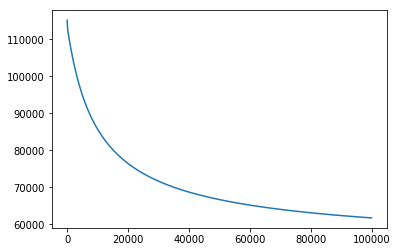

In [218]:
W_trained    = gradient_descent(TRAINING_PHI,y_train_OH,m,alpha=0.09,reg_param=2,iterations=100000)


In [228]:
W_trained    = gradient_descent(TRAINING_PHI,y_train_OH,m,alpha=0.09,reg_param=2,iterations=100000)

train_pred = softmax(np.dot(TRAINING_PHI,W_trained))
cv_pred = softmax(np.dot(VAL_PHI,W_trained))
test_pred = softmax(np.dot(TEST_PHI,W_trained))

preds = np.argmax(test_pred,axis=1)
print(preds.shape)
np.mean(y_test== preds)

(10000,)


0.5687

In [226]:
one_hot = np.argmax(test_pred,axis=1)
np.unique(one_hot)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])